## Plots for training of H1 rapgap MC with reconstructed observables as input.
### This version uses a single DNN with all inputs (electron, HFS, photons)

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess

mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 



In [2]:
has_gpu = False

#has_gpu = True

classification_training_name = 'training_h1_reg_v3a'

regression_training_name = 'training_h1_reg_v3a'

plot_isr_only = False
plot_fsr_only = False
plot_norad_only = False


xaxis_range = ''
#xaxis_range = 'medium'
#xaxis_range = 'wide'


save_plots = True

plots_dir = 'plots-h1-v3a-f3a'

#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
max_events = 1e9


learning_rate_setval = 1e-4
batch_size_setval = 128
max_epochs = 5000
dropout_setval = 0.0



input_file = '/data/owen/DIS-reco/h1-fullsim-2021-10-07-v3c/all-h1-rapgap.root'


plot_string = 'allevts'
if plot_isr_only :
    plot_string = 'isronly'
if plot_fsr_only :
    plot_string = 'fsronly'
if plot_norad_only :
    plot_string = 'noradonly'
    
if save_plots:
    try:
        os.mkdir( plots_dir )
    except:
        print('\n\n Plots output dir already exists: %s\n\n' % plots_dir )



 Plots output dir already exists: plots-h1-v3a-f3a




In [3]:
%%time


ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['Rapgap/minitree']
print(ur_tree)
ur_tree.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', ''
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'gen_eUncomb_E','gen_eUncomb_theta',
     'gen_HFS_Sigma','gen_HFS_T',
     'beam_e_e', 'beam_p_e',
     'wgt'
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7f8168b84c70>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
gen_new_Qi2s               (no streamer)              asdtype('>f4')
gen_new_xis                (no streamer)              asdtype('>f4')
gen_new_yis                (no streamer)              asdtype('>f4')
gen_new_Q2ida              (no streamer)              asdtype('>f4')
gen_new_xida               (no streamer)              asdtype('>f4')
gen_new_yida               (no streamer)              asdtype('>f4')
gen_HFS_Sigma              (no streamer)              asdtype('>f4')
gen_HFS_T                  (no streamer)              asdtype('>f4')
gen_eUncomb_E              (no streamer)           

In [4]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,obs_dphi,Empz,obs_e_trk_e,gen_eUncomb_E,gen_eUncomb_theta,gen_HFS_Sigma,gen_HFS_T,beam_e_e,beam_p_e,wgt
entry,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.962326,2.756099,0.260681,5.989288,27.6,920.000488,1.144036
1,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,11.565726,1.846050,12.046692,11.313186,27.6,920.000488,0.008928
2,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,26.595131,2.835472,2.928101,8.014862,27.6,920.000488,0.291180
3,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.094552,1.296305,2.860535,2.565612,27.6,920.000488,0.027073
4,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,21.916569,2.159615,21.111877,18.225756,27.6,920.000488,0.008928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61636816,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,10.022708,2.477417,37.285583,6.178102,27.6,920.000488,0.016648
61636817,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.575953,2.728113,25.361206,6.258389,27.6,920.000488,0.039054
61636818,0,1,24.007572,1,-0.637264,2.351282,1.337233,0.012592,0.013100,0.012119,...,3.124310,55.572090,21.544491,21.851133,2.465380,14.177917,14.363246,27.6,920.000488,0.013066


In [5]:
pandas_df.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [6]:
pandas_df.eval( 'gen_eBare_pt = gen_eUncomb_E * sin(gen_eUncomb_theta)', inplace=True )
pandas_df.eval( 'gen_eBare_pz = gen_eUncomb_E * cos(gen_eUncomb_theta)', inplace=True )
pandas_df.eval( 'gen_eBare_Sig_e = gen_eUncomb_E - gen_eBare_pz', inplace=True )


pandas_df.eval( 'gen_ptbal = 1. - gen_eBare_pt/gen_HFS_T', inplace=True )
pandas_df.eval( 'gen_pzbal = 1. - (gen_eBare_Sig_e + gen_HFS_Sigma)/(2.*beam_e_e)', inplace=True )

pandas_df.eval( 'gen_empz = gen_eBare_Sig_e + gen_HFS_Sigma', inplace=True )

pandas_df.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )

pandas_df.eval( 'obs_hfs_theta = arctan2(obs_hfs_pt,obs_hfs_pz)', inplace=True )


## Additional methods

In [7]:
pandas_df.eval( 'e = obs_e_e', inplace=True )
pandas_df.eval( 'e0 = beam_e_e', inplace=True )
pandas_df.eval( 'theta = arctan2( obs_e_pt, obs_e_pz)', inplace=True )
pandas_df.eval( 'sin_theta = sin(theta)', inplace=True )
pandas_df.eval( 'cos_theta = cos(theta)', inplace=True )
pandas_df.eval( 'Sigma = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df.eval( 'Sigma_e = obs_e_e - obs_e_pz', inplace=True )
pandas_df['tan_theta_over_2'] = np.tan(pandas_df['theta']/2.)

pandas_df.eval( 'T = obs_hfs_pt', inplace=True )
pandas_df.eval( 'tan_gamma_over_2 = Sigma / T', inplace=True )
pandas_df.eval( 'ep = beam_p_e', inplace=True )
pandas_df.eval( 'eh = obs_hfs_e', inplace=True )

### Sigma

In [8]:

pandas_df.eval( 'obs_y_sigma = Sigma / ( Sigma + Sigma_e )', inplace=True )

pandas_df.eval( 'obs_q2_sigma = e * e * sin_theta * sin_theta / ( 1. - obs_y_sigma )', inplace=True )

pandas_df.eval( 'obs_x_sigma   =   obs_q2_sigma / ( 4. * ep * e0 * obs_y_sigma )', inplace=True )


### E Sigma T

In [9]:

pandas_df.eval( 'obs_y_esigmat    =    Sigma / ( Sigma + e + sqrt( e*e + T*T ) )', inplace=True )

pandas_df.eval( 'obs_q2_esigmat   =    T * T / ( 1. - obs_y_esigmat )', inplace=True )

pandas_df.eval( 'obs_x_esigmat   =   obs_q2_esigmat / ( 2. * ep * Sigma )', inplace=True )


### E0 E T

In [10]:

pandas_df.eval( 'obs_y_e0et   =   ( 2*e0 - e - sqrt( e*e - T*T ) ) / ( 2 * e0 )', inplace=True )

pandas_df.eval( 'obs_q2_e0et   =   T * T / ( 1. - obs_y_e0et )', inplace=True )

pandas_df.eval( 'obs_x_e0et   =   obs_q2_e0et / ( 4. * ep * e0 * obs_y_e0et )', inplace=True )




### IDA

In [11]:

pandas_df['obs_y_ida'] =   pandas_df['obs_y[6]'] 

pandas_df['obs_q2_ida'] =   pandas_df['obs_Q2[6]'] 

pandas_df['obs_x_ida'] =   pandas_df['obs_x[6]'] 




### eSigma

In [12]:

pandas_df['obs_y_esigma'] =   pandas_df['obs_y[8]'] 

pandas_df['obs_q2_esigma'] =   pandas_df['obs_Q2[8]'] 

pandas_df['obs_x_esigma'] =   pandas_df['obs_x[8]'] 



### E0 E Sigma

In [13]:

pandas_df['obs_y_e0esigma'] =   pandas_df['obs_y[1]'] 

pandas_df['obs_q2_e0esigma'] =   pandas_df['obs_Q2[1]'] 

pandas_df['obs_x_e0esigma'] =   pandas_df['obs_x[1]'] 




### E0 theta Sigma

In [14]:

pandas_df['obs_y_e0thetasigma'] =   pandas_df['obs_y[2]'] 

pandas_df['obs_q2_e0thetasigma'] =   pandas_df['obs_Q2[2]'] 

pandas_df['obs_x_e0thetasigma'] =   pandas_df['obs_x[2]'] 




### Theta Sigma gamma

In [15]:

pandas_df.eval( 'obs_y_thetasigmagamma   =   tan_gamma_over_2 / ( tan_gamma_over_2 + tan_theta_over_2 )', inplace=True )

pandas_df.eval( 'obs_q2_thetasigmagamma   =   T * T / ( 1. - obs_y_thetasigmagamma )', inplace=True )

pandas_df.eval( 'obs_x_thetasigmagamma   =   obs_q2_thetasigmagamma / ( 2. * ep * Sigma )', inplace=True )




In [16]:
pandas_df

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,obs_x_esigma,obs_y_e0esigma,obs_q2_e0esigma,obs_x_e0esigma,obs_y_e0thetasigma,obs_q2_e0thetasigma,obs_x_e0thetasigma,obs_y_thetasigmagamma,obs_q2_thetasigmagamma,obs_x_thetasigmagamma
entry,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
2,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
3,1,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
4,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61636816,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
61636817,0,0,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
61636818,0,1,24.007572,1,-0.637264,2.351282,1.337233,0.012592,0.013100,0.012119,...,0.012307,0.231056,307.432190,0.013100,0.231056,284.399933,0.012119,0.252271,231.993852,0.009886


## Apply any event selection here.

In [17]:
pandas_df = pandas_df.query('Empz > 0')



#pandas_df = pandas_df.query('obs_event_Empz > 46 and obs_event_Empz < 62')

#-- 2021-10-07 tighter Empz cut
pandas_df = pandas_df.query('obs_event_Empz > 50 and obs_event_Empz < 60')

#-- 2021-10-07 new cut
########### pandas_df = pandas_df.query('not (obs_hfs_theta<0.35 and obs_event_Empz>56 )')




pandas_df = pandas_df.query('gen_empz > 44 and gen_empz < 64')

pandas_df = pandas_df.query('obs_hfs_pt > 0')

pandas_df = pandas_df.query('from_tlv_gen_Q2 > 200')

pandas_df = pandas_df.query('e_ecal_over_trk_ratio > 0')

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )

if plot_isr_only :
    pandas_df = pandas_df.query('has_isr == 1')
    
if plot_fsr_only :
    pandas_df = pandas_df.query('has_fsr == 1')    

if plot_norad_only :
    pandas_df = pandas_df.query('has_fsr == 0 and has_isr == 0')   
    
print('\n\n Number of subset entries in pandas_df:  %d ' % pandas_df.shape[0] )





 Number of entries in pandas_df:  10661295 


 Number of subset entries in pandas_df:  10661295 


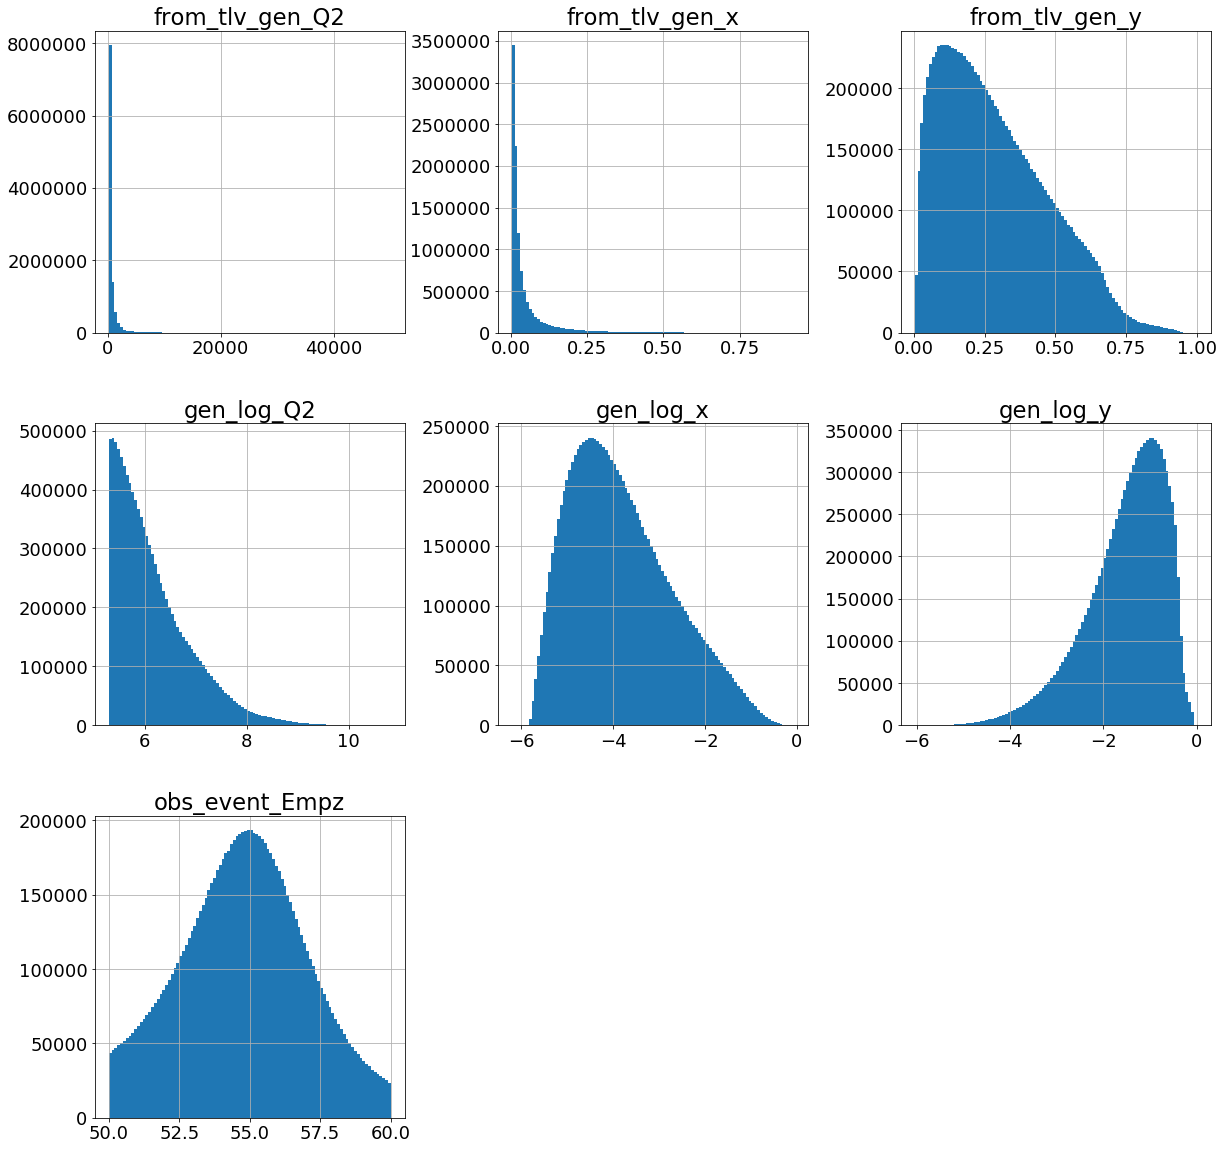

In [18]:
pandas_df.hist( figsize=(20,20), bins=100, column=['from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz',
                        ])
plt.show()

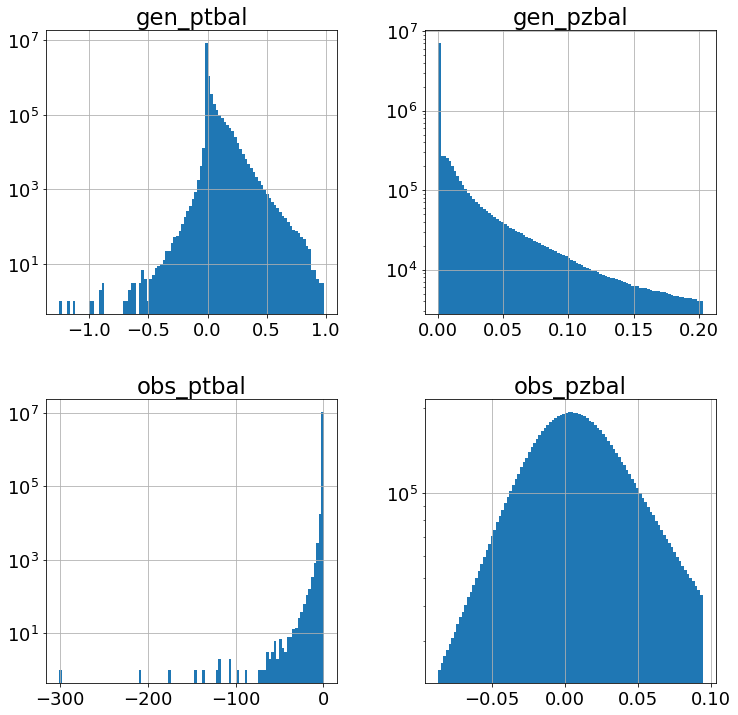

In [19]:
pandas_df.hist( figsize=(12,12), bins=100, column=[
                        'gen_pzbal','gen_ptbal',
                        'obs_ptbal','obs_pzbal'
                        ], log=True)
plt.show()

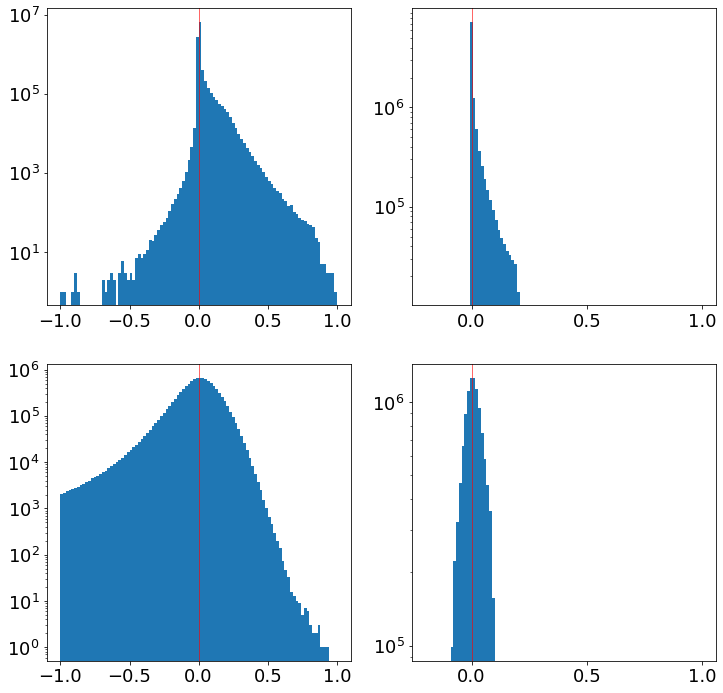

In [20]:
fig,ax = plt.subplots(2,2,figsize=(12,12))

ax[0][0].hist(pandas_df['gen_ptbal'],bins=100, range=[-1,1] )
ax[0][1].hist(pandas_df['gen_pzbal'],bins=100, range=[-0.2,1] )

ax[1][0].hist(pandas_df['obs_ptbal'],bins=100, range=[-1,1] )
ax[1][1].hist(pandas_df['obs_pzbal'],bins=100, range=[-0.2,1] )

ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
ax[1][0].set_yscale('log')
ax[1][1].set_yscale('log')

for i in range(2):
   for j in range(2):
    ax[i][j].axvline(0.0,color='red',lw=1,alpha=0.6)

plt.show()


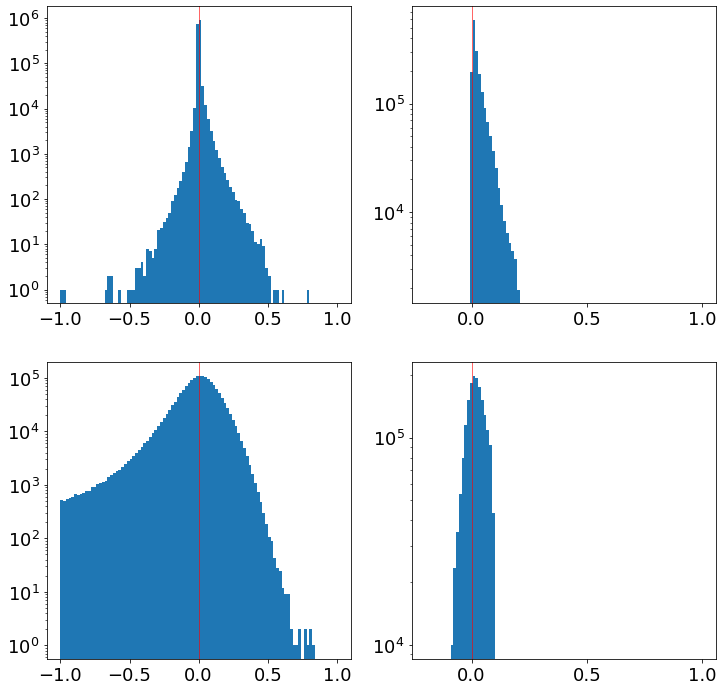

In [21]:
fig,ax = plt.subplots(2,2,figsize=(12,12))

cuts = 'has_isr==1'

ax[0][0].hist(pandas_df.query(cuts)['gen_ptbal'],bins=100, range=[-1,1] )
ax[0][1].hist(pandas_df.query(cuts)['gen_pzbal'],bins=100, range=[-0.2,1] )

ax[1][0].hist(pandas_df.query(cuts)['obs_ptbal'],bins=100, range=[-1,1] )
ax[1][1].hist(pandas_df.query(cuts)['obs_pzbal'],bins=100, range=[-0.2,1] )

ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
ax[1][0].set_yscale('log')
ax[1][1].set_yscale('log')

for i in range(2):
   for j in range(2):
    ax[i][j].axvline(0.0,color='red',lw=1,alpha=0.6)

plt.show()

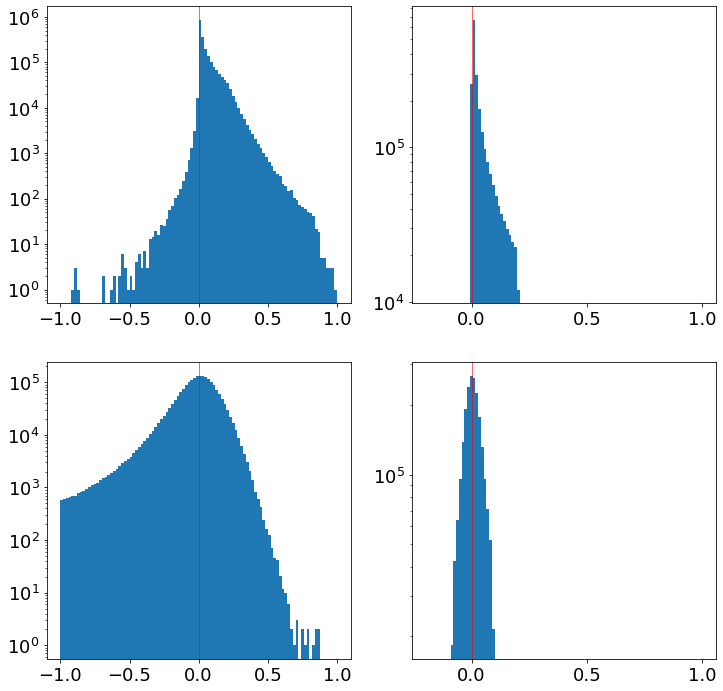

In [22]:
fig,ax = plt.subplots(2,2,figsize=(12,12))

cuts = 'has_fsr==1'

ax[0][0].hist(pandas_df.query(cuts)['gen_ptbal'],bins=100, range=[-1,1] )
ax[0][1].hist(pandas_df.query(cuts)['gen_pzbal'],bins=100, range=[-0.2,1] )

ax[1][0].hist(pandas_df.query(cuts)['obs_ptbal'],bins=100, range=[-1,1] )
ax[1][1].hist(pandas_df.query(cuts)['obs_pzbal'],bins=100, range=[-0.2,1] )

ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
ax[1][0].set_yscale('log')
ax[1][1].set_yscale('log')

for i in range(2):
   for j in range(2):
    ax[i][j].axvline(0.0,color='red',lw=1,alpha=0.6)

plt.show()

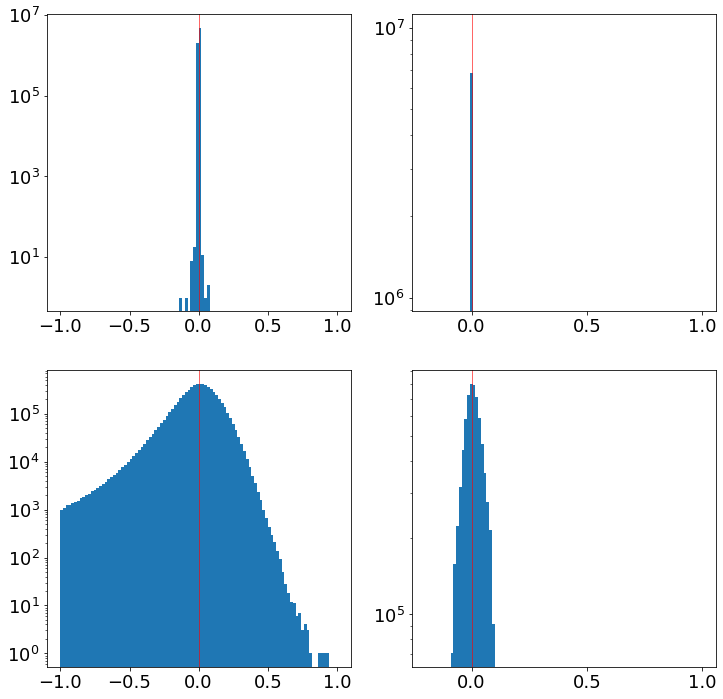

In [23]:
fig,ax = plt.subplots(2,2,figsize=(12,12))

cuts = 'has_fsr==0 and has_isr==0'

ax[0][0].hist(pandas_df.query(cuts)['gen_ptbal'],bins=100, range=[-1,1] )
ax[0][1].hist(pandas_df.query(cuts)['gen_pzbal'],bins=100, range=[-0.2,1] )

ax[1][0].hist(pandas_df.query(cuts)['obs_ptbal'],bins=100, range=[-1,1] )
ax[1][1].hist(pandas_df.query(cuts)['obs_pzbal'],bins=100, range=[-0.2,1] )

ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
ax[1][0].set_yscale('log')
ax[1][1].set_yscale('log')

for i in range(2):
   for j in range(2):
    ax[i][j].axvline(0.0,color='red',lw=1,alpha=0.6)

plt.show()

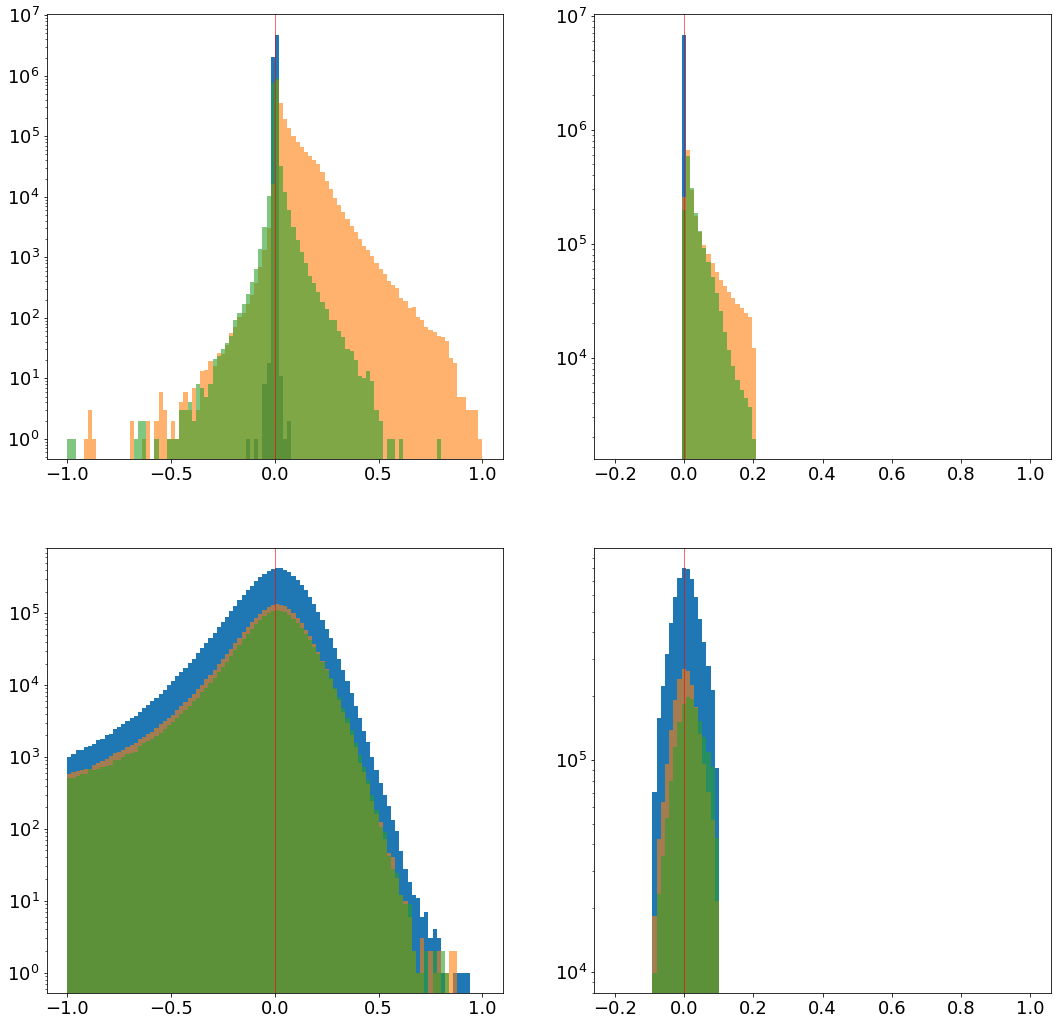

In [24]:
fig,ax = plt.subplots(2,2,figsize=(18,18))

cuts = 'has_fsr==0 and has_isr==0'

ax[0][0].hist(pandas_df.query(cuts)['gen_ptbal'],bins=100, range=[-1,1] )
ax[0][1].hist(pandas_df.query(cuts)['gen_pzbal'],bins=100, range=[-0.2,1] )

ax[1][0].hist(pandas_df.query(cuts)['obs_ptbal'],bins=100, range=[-1,1] )
ax[1][1].hist(pandas_df.query(cuts)['obs_pzbal'],bins=100, range=[-0.2,1] )


cuts = 'has_fsr==1'

ax[0][0].hist(pandas_df.query(cuts)['gen_ptbal'],bins=100, range=[-1,1], alpha=0.6 )
ax[0][1].hist(pandas_df.query(cuts)['gen_pzbal'],bins=100, range=[-0.2,1], alpha=0.6 )

ax[1][0].hist(pandas_df.query(cuts)['obs_ptbal'],bins=100, range=[-1,1], alpha=0.6 )
ax[1][1].hist(pandas_df.query(cuts)['obs_pzbal'],bins=100, range=[-0.2,1], alpha=0.6 )


cuts = 'has_isr==1'

ax[0][0].hist(pandas_df.query(cuts)['gen_ptbal'],bins=100, range=[-1,1], alpha=0.6 )
ax[0][1].hist(pandas_df.query(cuts)['gen_pzbal'],bins=100, range=[-0.2,1], alpha=0.6 )

ax[1][0].hist(pandas_df.query(cuts)['obs_ptbal'],bins=100, range=[-1,1], alpha=0.6 )
ax[1][1].hist(pandas_df.query(cuts)['obs_pzbal'],bins=100, range=[-0.2,1], alpha=0.6 )

ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
ax[1][0].set_yscale('log')
ax[1][1].set_yscale('log')

for i in range(2):
   for j in range(2):
    ax[i][j].axvline(0.0,color='red',lw=1,alpha=0.6)

plt.show()

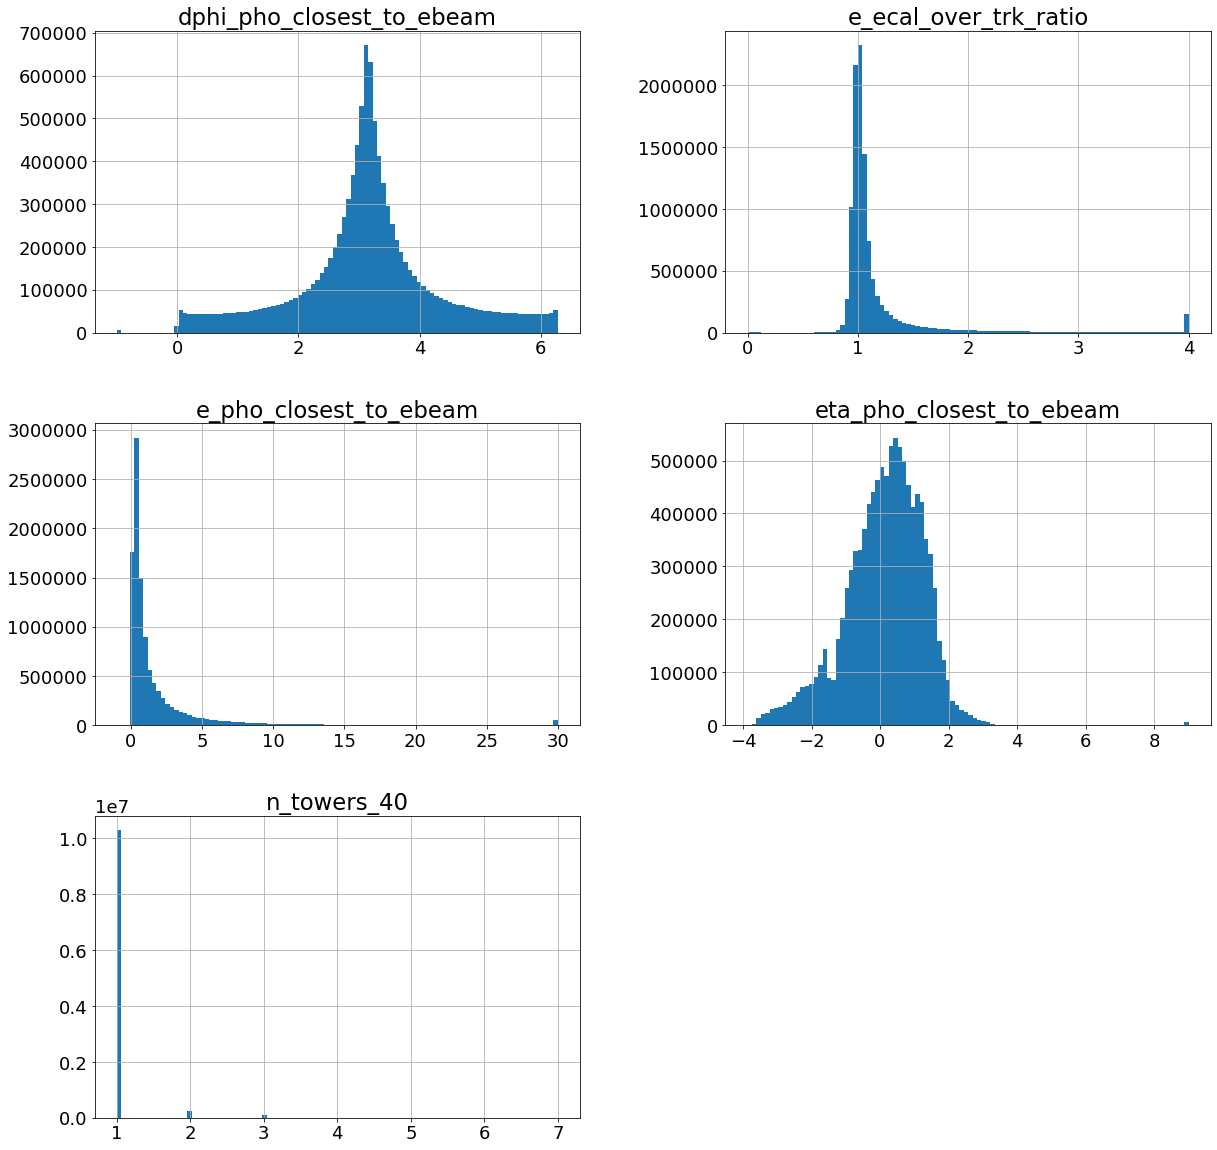

In [25]:
pandas_df.hist( figsize=(20,20), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()

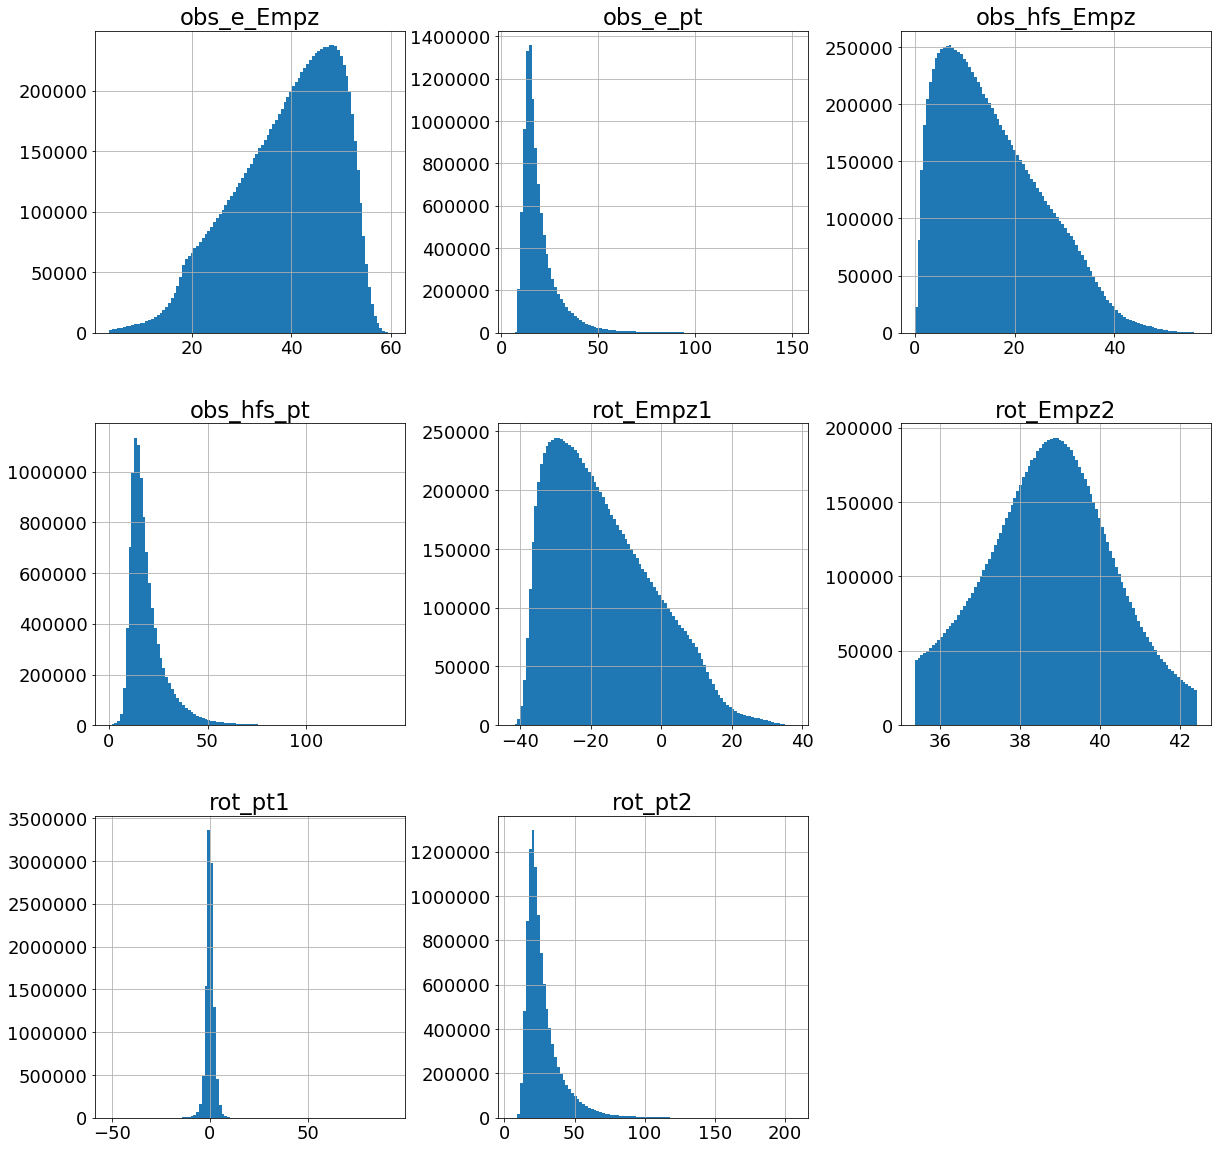

In [26]:
pandas_df.hist( figsize=(20,20), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1','rot_Empz2',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

                                                   
plt.show()

## Set up machine learning stuff

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pickle import load

#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#####physical_devices = tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
X = np.c_[
    pandas_df['e_ecal_over_trk_ratio'].to_numpy(),
    pandas_df['n_towers_40'].to_numpy(),
    pandas_df['eta_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['e_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['dphi_pho_closest_to_ebeam'].to_numpy(),
    pandas_df['obs_e_pz'].to_numpy(),
    pandas_df['obs_e_e'].to_numpy(),
    pandas_df['obs_hfs_pz'].to_numpy(),
    pandas_df['obs_hfs_e'].to_numpy(),
    pandas_df['rot_pt1'].to_numpy(),
    pandas_df['rot_Empz1'].to_numpy(),
    pandas_df['rot_pt2'].to_numpy(),
    ##### pandas_df['rot_Empz2'].to_numpy(),
    pandas_df['obs_pzbal'].to_numpy(),
    pandas_df['obs_ptbal'].to_numpy(),
    pandas_df['obs_dphi'].to_numpy(),
]

#-- targets for classification
Y = np.c_[ 
    pandas_df['gen_ptbal'].to_numpy(),
    pandas_df['gen_pzbal'].to_numpy(),
]

#-- targets for regression
Y_r = np.c_[
    pandas_df['gen_log_x'].to_numpy(),
    pandas_df['gen_log_Q2'].to_numpy(),
    pandas_df['gen_log_y'].to_numpy(),
]


#-- extras
Ex_obs_e = np.c_[
    pandas_df['obs_x[0]'].to_numpy(),
    pandas_df['obs_Q2[0]'].to_numpy(),
    pandas_df['obs_y[0]'].to_numpy(),
]
Ex_obs_da = np.c_[
    pandas_df['obs_x[3]'].to_numpy(),
    pandas_df['obs_Q2[3]'].to_numpy(),
    pandas_df['obs_y[3]'].to_numpy(),
]
Ex_obs_h = np.c_[
    pandas_df['obs_x[4]'].to_numpy(),
    pandas_df['obs_Q2[4]'].to_numpy(),
    pandas_df['obs_y[4]'].to_numpy(),
]
Ex_obs_is = np.c_[
    pandas_df['obs_x[5]'].to_numpy(),
    pandas_df['obs_Q2[5]'].to_numpy(),
    pandas_df['obs_y[5]'].to_numpy(),
]
Ex_wgt = np.c_[
    pandas_df['wgt'].to_numpy(),
]
Ex_isrfsr =  np.c_[
    pandas_df['has_isr'].to_numpy(),
    pandas_df['has_fsr'].to_numpy(),
    pandas_df['has_norad'].to_numpy(),
]
    
GY = pandas_df['from_tlv_gen_y'].to_numpy()



#-- Load the scaler transformations!  These are essential when reusing the training with a different dataset.

scaler = load( open('%s-scalers/input_scaler.pkl' % classification_training_name, 'rb'))
X = scaler.transform(X)

scalerY_c = load( open('%s-scalers/target_scaler_c.pkl' % classification_training_name , 'rb'))
Y = scalerY_c.transform(Y)

scalerY = load( open('%s-scalers/target_scaler.pkl' % classification_training_name , 'rb'))
Y_r = scalerY.transform(Y_r)



X_train, X_test,    Y_train, Y_test,    Y_r_train, Y_r_test,    GY_train, GY_test,  Ex_obs_e_train, Ex_obs_e_test,  Ex_obs_da_train, Ex_obs_da_test,   Ex_obs_h_train, Ex_obs_h_test,  Ex_obs_is_train, Ex_obs_is_test,   Ex_wgt_train, Ex_wgt_test,  Ex_isrfsr_train, Ex_isrfsr_test = train_test_split( X, Y, Y_r, GY, Ex_obs_e, Ex_obs_da, Ex_obs_h, Ex_obs_is, Ex_wgt, Ex_isrfsr, test_size=0.5)
    

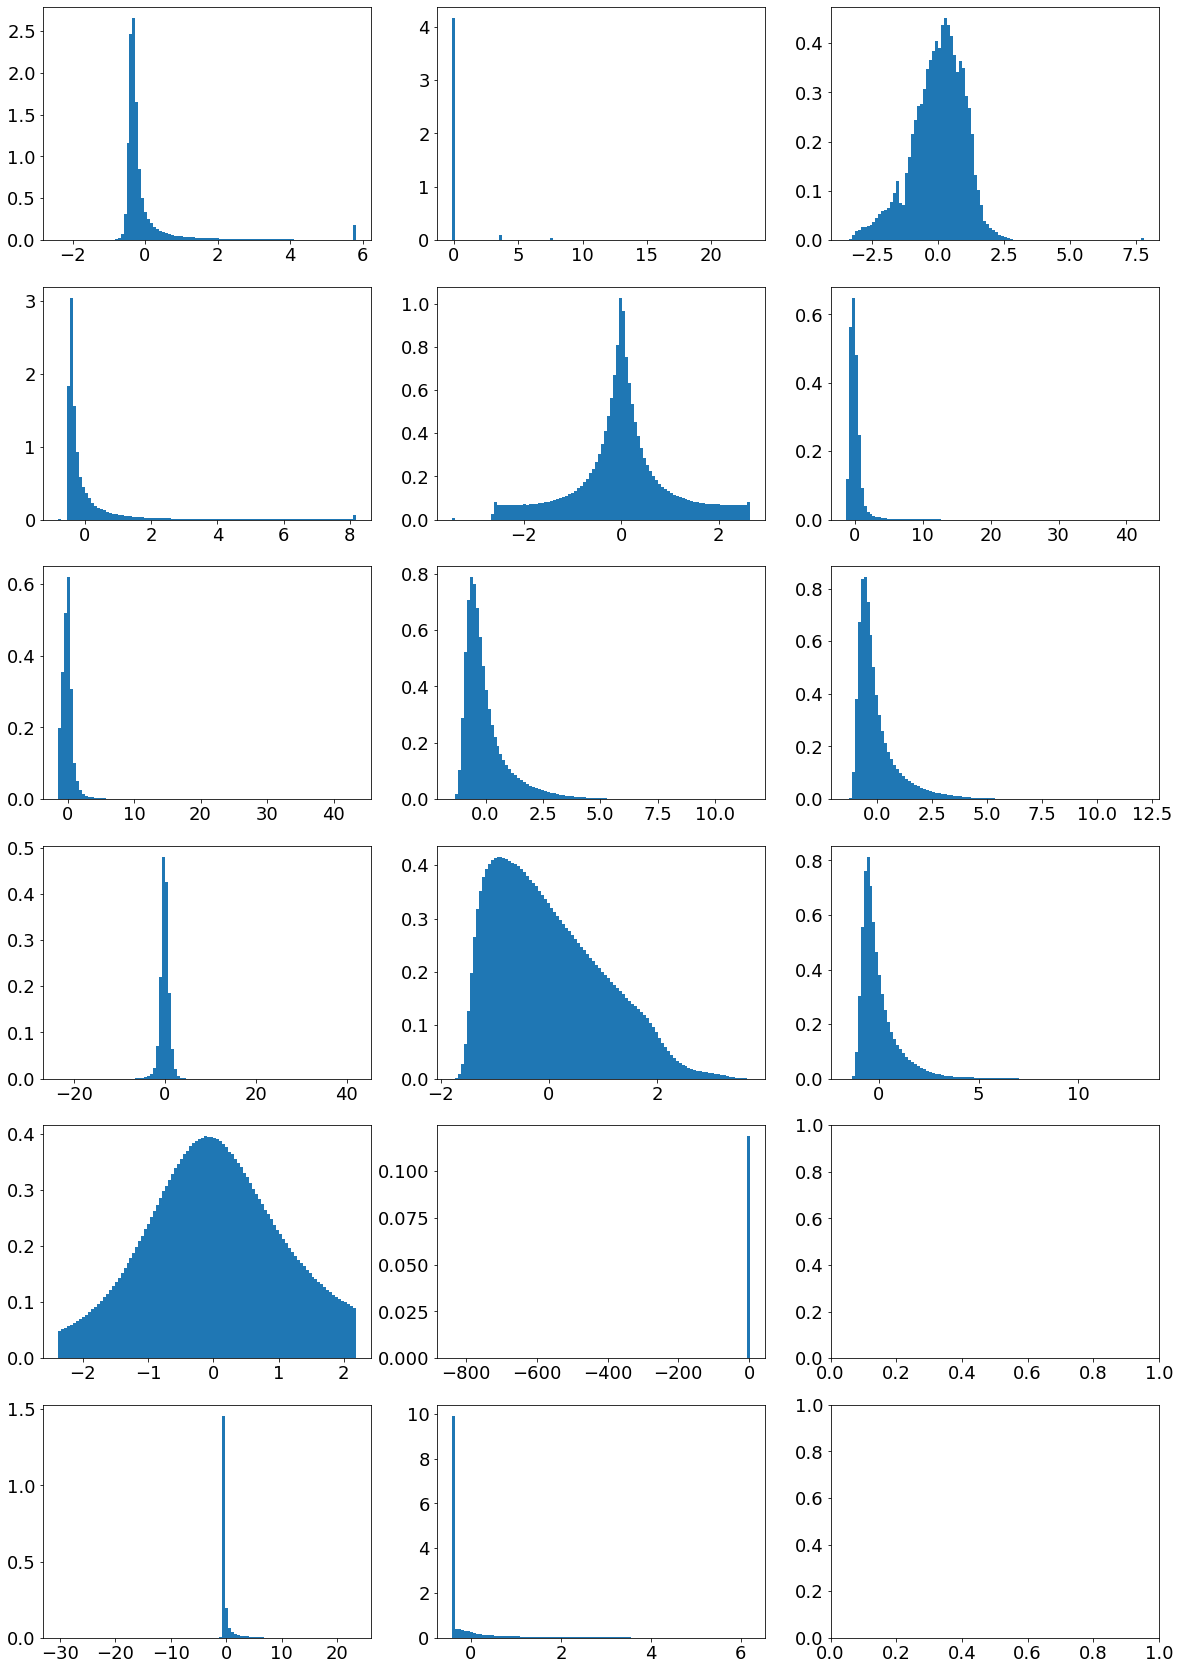

In [29]:
fig,ax = plt.subplots(6,3,figsize=(20,30))

ax[0][0].hist( X[:,0], density=True, bins=100 )
ax[0][1].hist( X[:,1], density=True, bins=100 )
ax[0][2].hist( X[:,2], density=True, bins=100 )

ax[1][0].hist( X[:,3], density=True, bins=100 )
ax[1][1].hist( X[:,4], density=True, bins=100 )
ax[1][2].hist( X[:,5], density=True, bins=100 )

ax[2][0].hist( X[:,6], density=True, bins=100 )
ax[2][1].hist( X[:,7], density=True, bins=100 )
ax[2][2].hist( X[:,8], density=True, bins=100 )

ax[3][0].hist( X[:,9], density=True, bins=100 )
ax[3][1].hist( X[:,10], density=True, bins=100 )
ax[3][2].hist( X[:,11], density=True, bins=100 )

ax[4][0].hist( X[:,12], density=True, bins=100 )
ax[4][1].hist( X[:,13], density=True, bins=100 )



ax[5][0].hist( Y[:,0], density=True, bins=100 )
ax[5][1].hist( Y[:,1], density=True, bins=100 )


plt.show()

## Set up the regression network

In [30]:
model_r = tf.keras.models.load_model('%s_regression' % regression_training_name )
model_r.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1024      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              5

In [31]:
mypreds_r = model_r.predict(X_test,batch_size=1000)

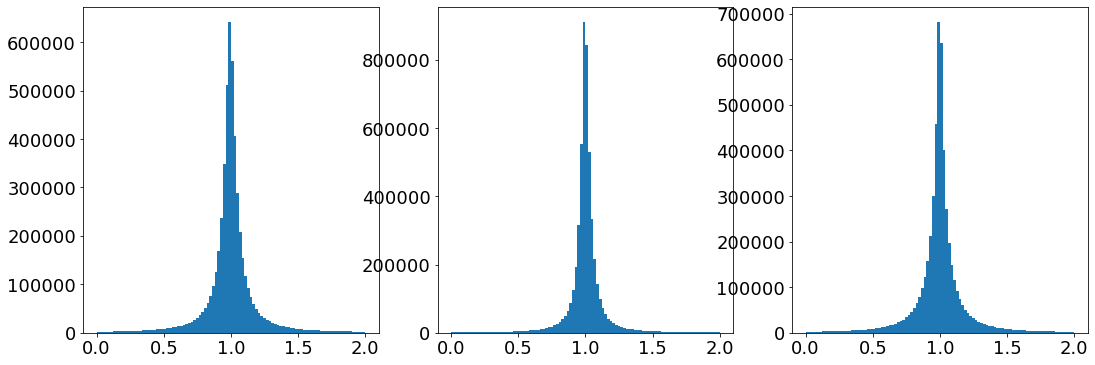

In [32]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].hist(mypreds_r[:,0]/Y_r_test[:,0],bins=100, range=[0,2] )
ax[1].hist(mypreds_r[:,1]/Y_r_test[:,1],bins=100, range=[0,2] )
ax[2].hist(mypreds_r[:,2]/Y_r_test[:,2],bins=100, range=[0,2] )
plt.show()

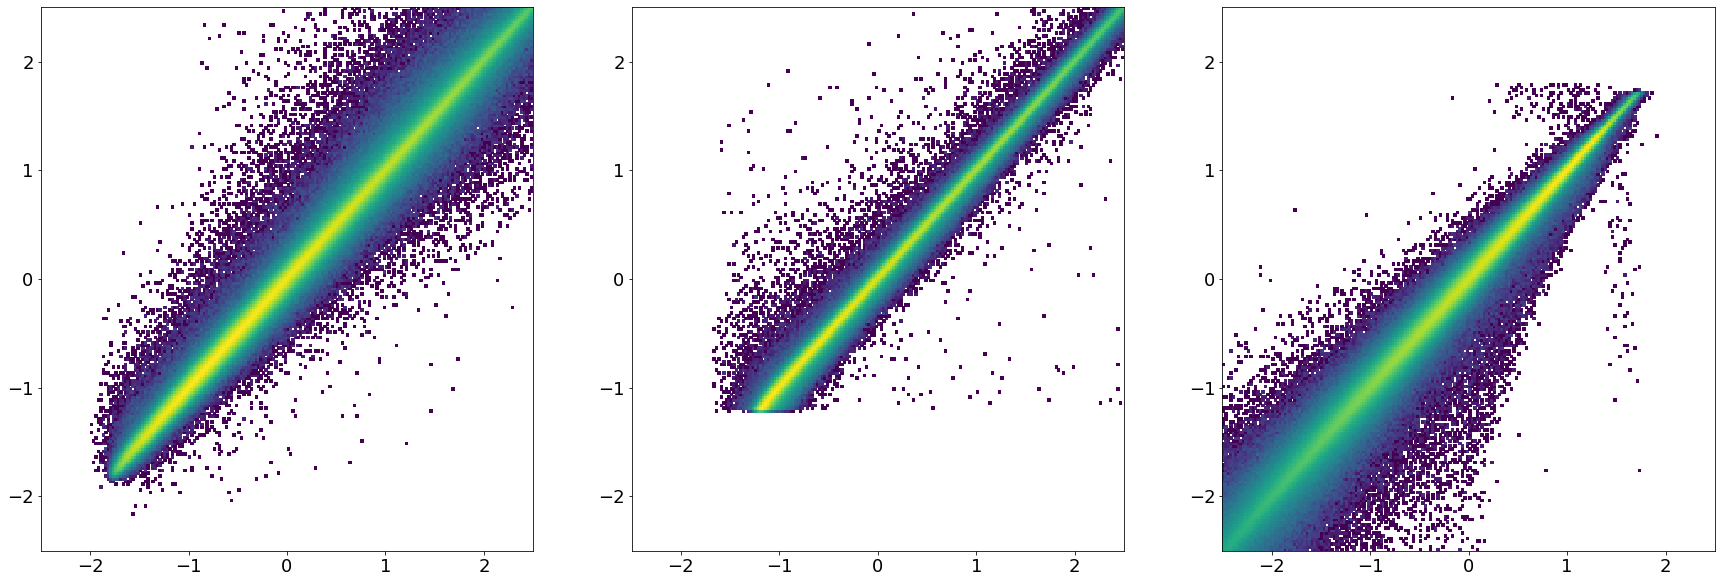

In [33]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].hist2d(mypreds_r[:,0],Y_r_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[1].hist2d(mypreds_r[:,1],Y_r_test[:,1],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
ax[2].hist2d(mypreds_r[:,2],Y_r_test[:,2],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

In [34]:
inv_trans_Y = scalerY.inverse_transform(Y_r_test)
inv_trans_pred = scalerY.inverse_transform(mypreds_r)
true_vals = np.exp( inv_trans_Y )
pred_vals = np.exp( inv_trans_pred )

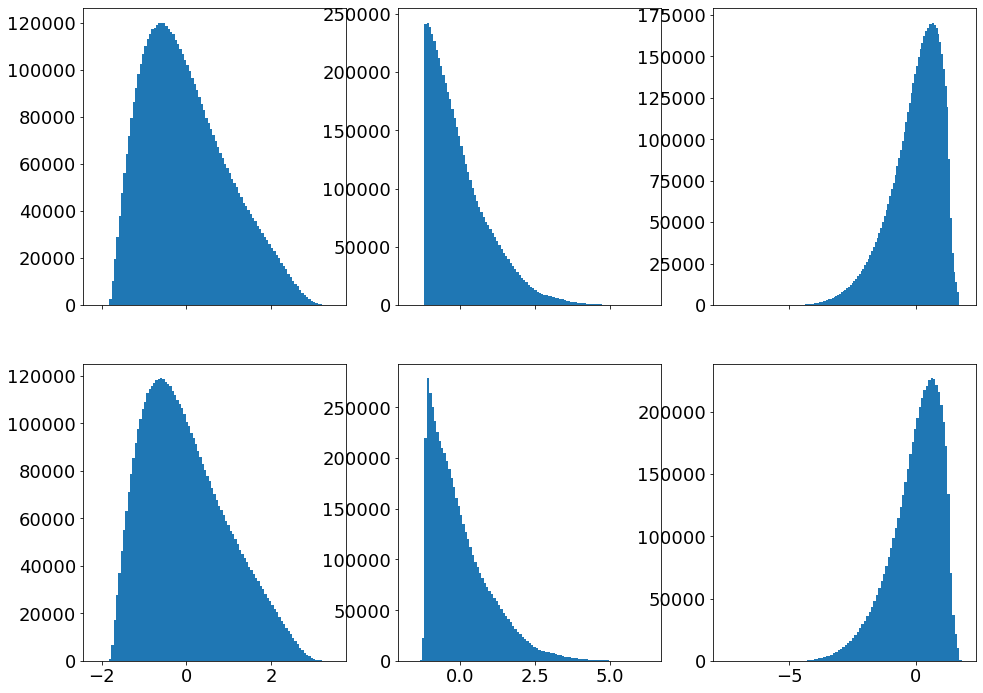

In [35]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col')

ax[0][0].hist(Y_r_test[:,0], bins=100)
ax[0][1].hist(Y_r_test[:,1], bins=100)
ax[0][2].hist(Y_r_test[:,2], bins=100)

ax[1][0].hist(mypreds_r[:,0], bins=100)
ax[1][1].hist(mypreds_r[:,1], bins=100)
ax[1][2].hist(mypreds_r[:,2], bins=100)


plt.show()

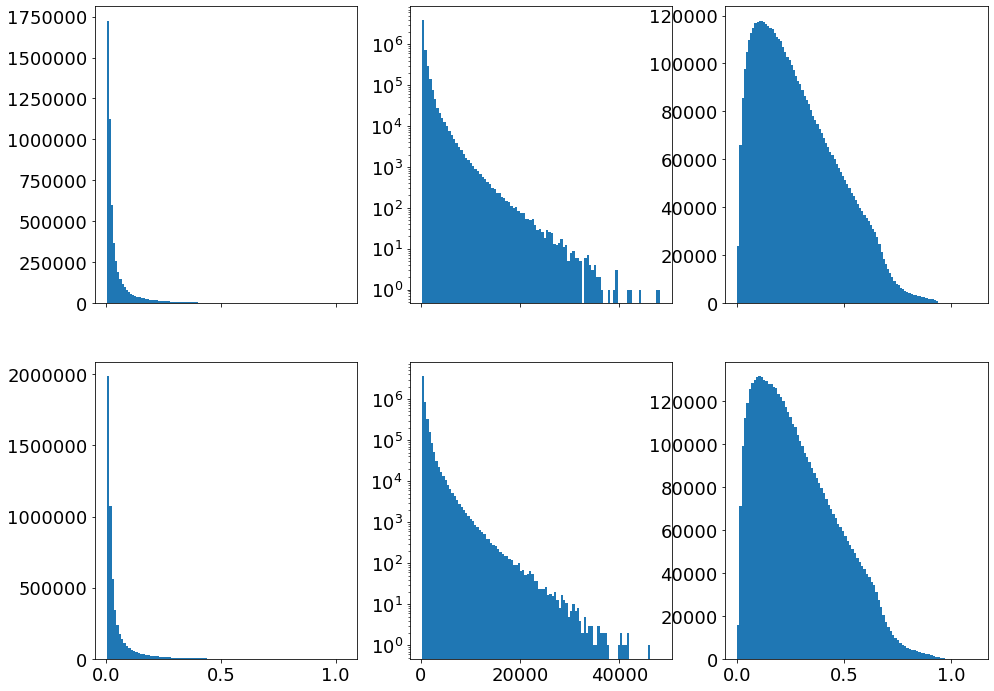

In [36]:
fig,ax = plt.subplots(2,3,figsize=(16,12), sharex='col' )



ax[0][0].hist(true_vals[:,0], bins=100)
ax[0][1].hist(true_vals[:,1], bins=100)
ax[0][2].hist(true_vals[:,2], bins=100)

ax[1][0].hist(pred_vals[:,0], bins=100)
ax[1][1].hist(pred_vals[:,1], bins=100)
ax[1][2].hist(pred_vals[:,2], bins=100)


ax[0][1].set_yscale('log')
ax[1][1].set_yscale('log')


plt.show()

## Plots of pred/true of training target variables : transformed log(x), log(y), and log(Q2)

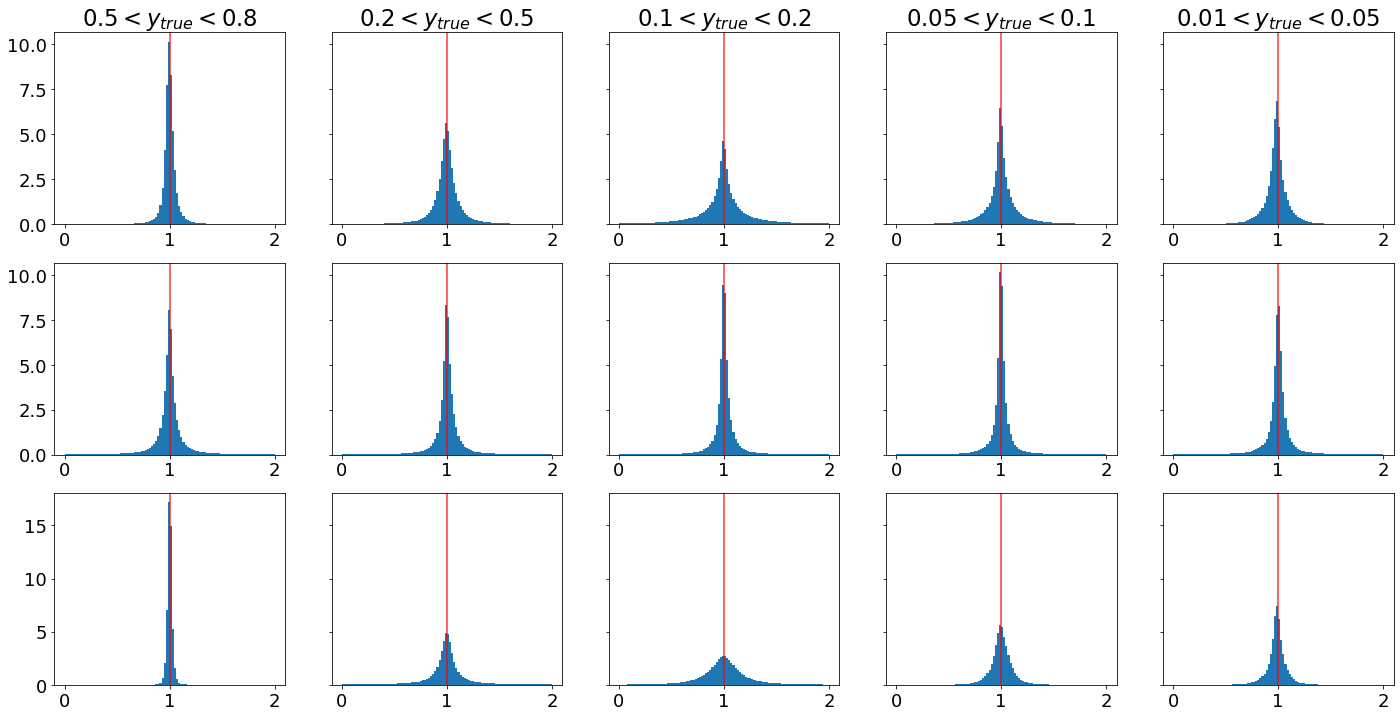

In [37]:
fig,ax = plt.subplots(3,5,figsize=(24,12),sharey='row')

for i in range(3):
    ax[i][0].hist(mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)]/Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],density=True,bins=100,range=(0,2))
    ax[i][1].hist(mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)]/Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],density=True,bins=100,range=(0,2))
    ax[i][2].hist(mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)]/Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],density=True,bins=100,range=(0,2))
    ax[i][3].hist(mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)]/Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],density=True,bins=100,range=(0,2))
    ax[i][4].hist(mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)]/Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],density=True,bins=100,range=(0,2))



ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[0][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[1][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    ax[2][i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()


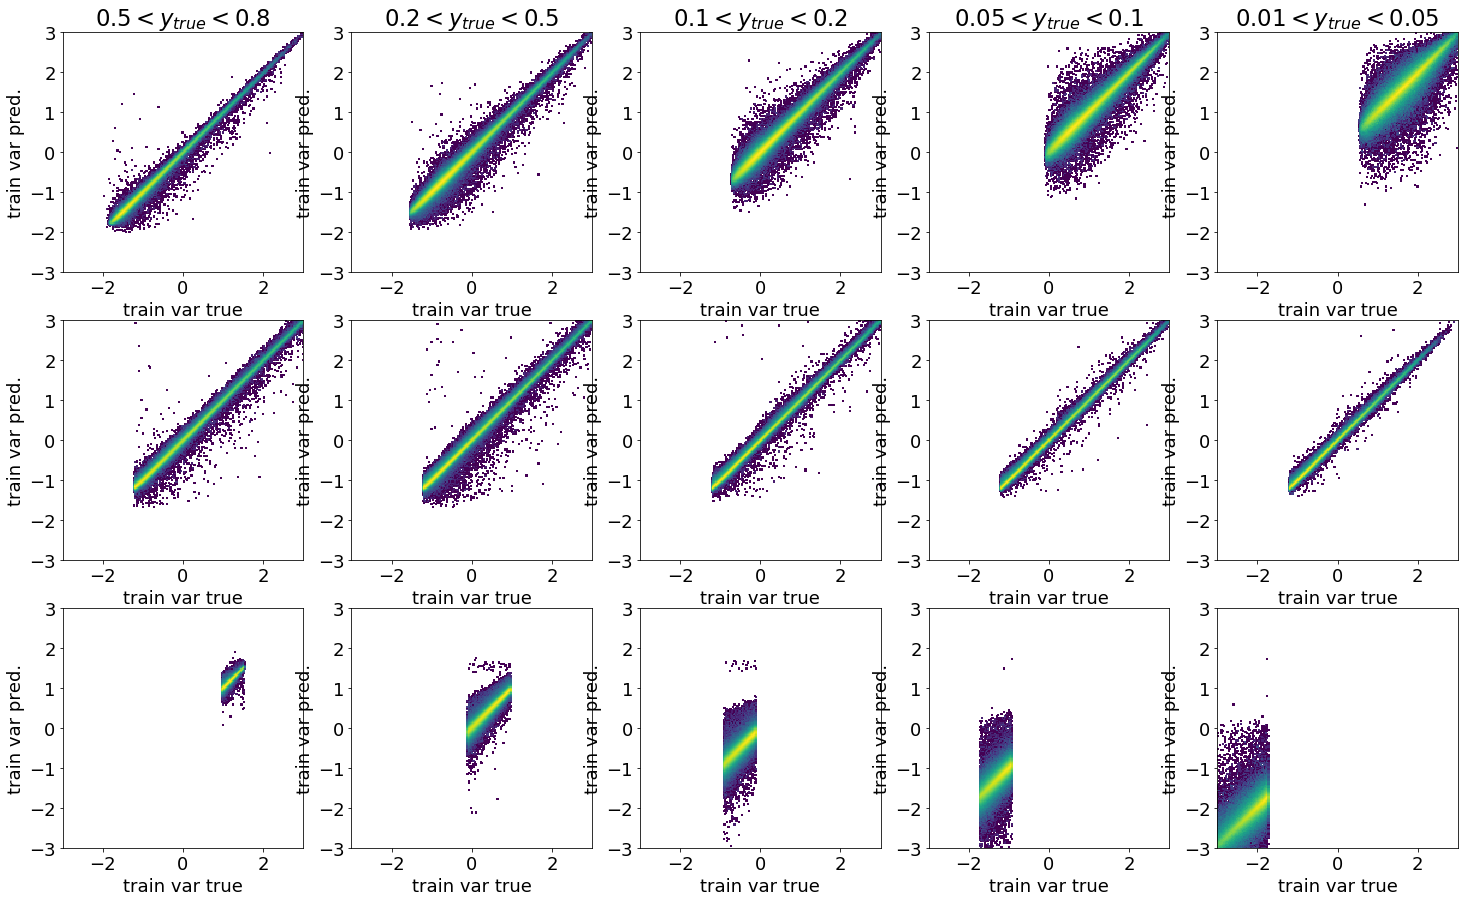

In [38]:
fig,ax = plt.subplots(3,5,figsize=(25,15))


for i in range(3):
    ax[i][0].hist2d( Y_r_test[(GY_test > 0.5)*(GY_test < 0.8)][:,i],
              mypreds_r[:,i][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][1].hist2d( Y_r_test[(GY_test > 0.2)*(GY_test < 0.5)][:,i],
              mypreds_r[:,i][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][2].hist2d( Y_r_test[(GY_test > 0.1)*(GY_test < 0.2)][:,i],
              mypreds_r[:,i][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][3].hist2d( Y_r_test[(GY_test > 0.05)*(GY_test < 0.1)][:,i],
              mypreds_r[:,i][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

    ax[i][4].hist2d( Y_r_test[(GY_test > 0.01)*(GY_test < 0.05)][:,i],
              mypreds_r[:,i][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())
    
ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')




for i in range(5):
    ax[0][i].set_ylabel('train var pred.')
    ax[0][i].set_xlabel('train var true')
    ax[1][i].set_ylabel('train var pred.')
    ax[1][i].set_xlabel('train var true')
    ax[2][i].set_ylabel('train var pred.')
    ax[2][i].set_xlabel('train var true')



    
plt.show()


## Plots of predicted and true physics variable : x

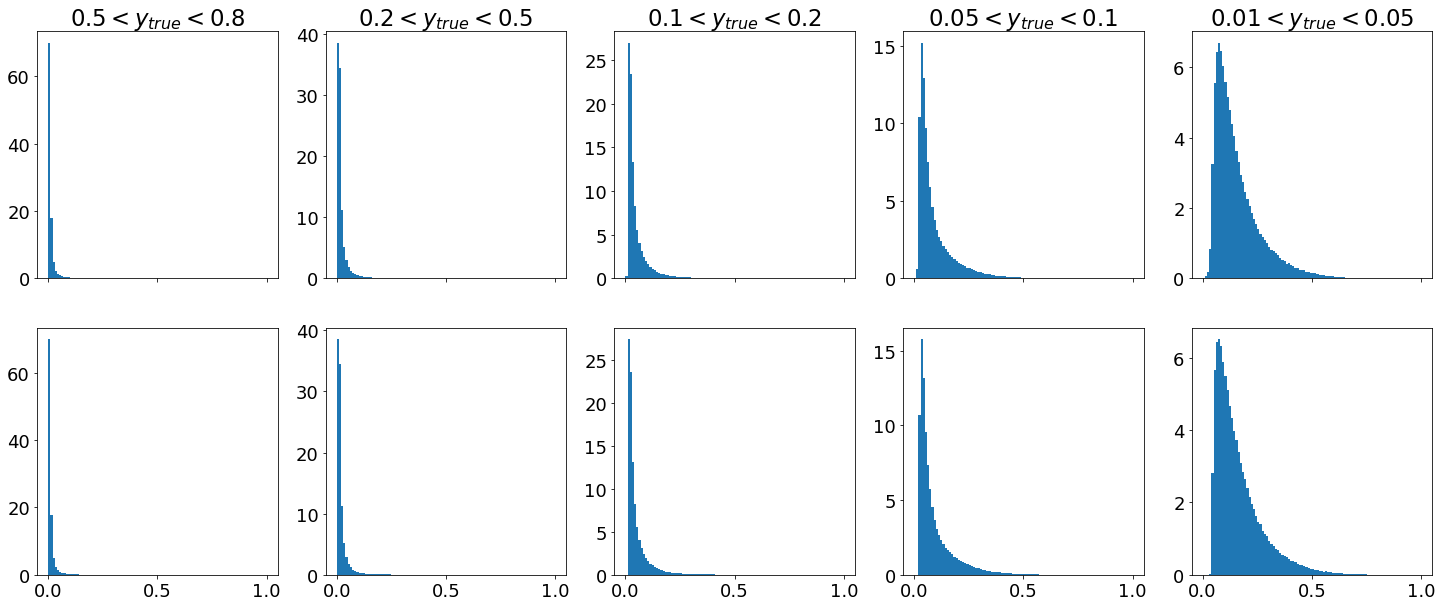

In [39]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,1))
ax[1][1].hist(true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,1))
ax[1][2].hist(true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,1))
ax[1][3].hist(true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,1))
ax[1][4].hist(true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

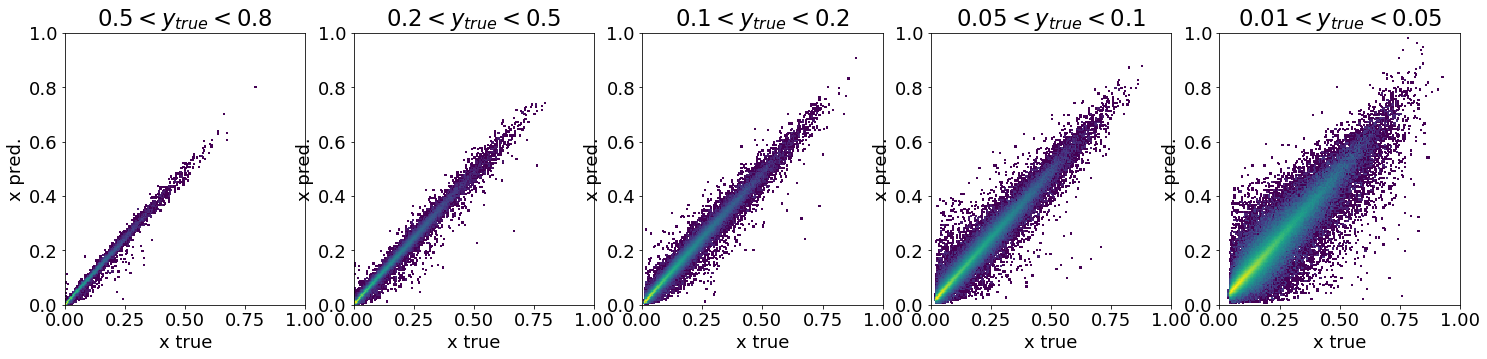

In [40]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of predicted and true physics variable : Q2

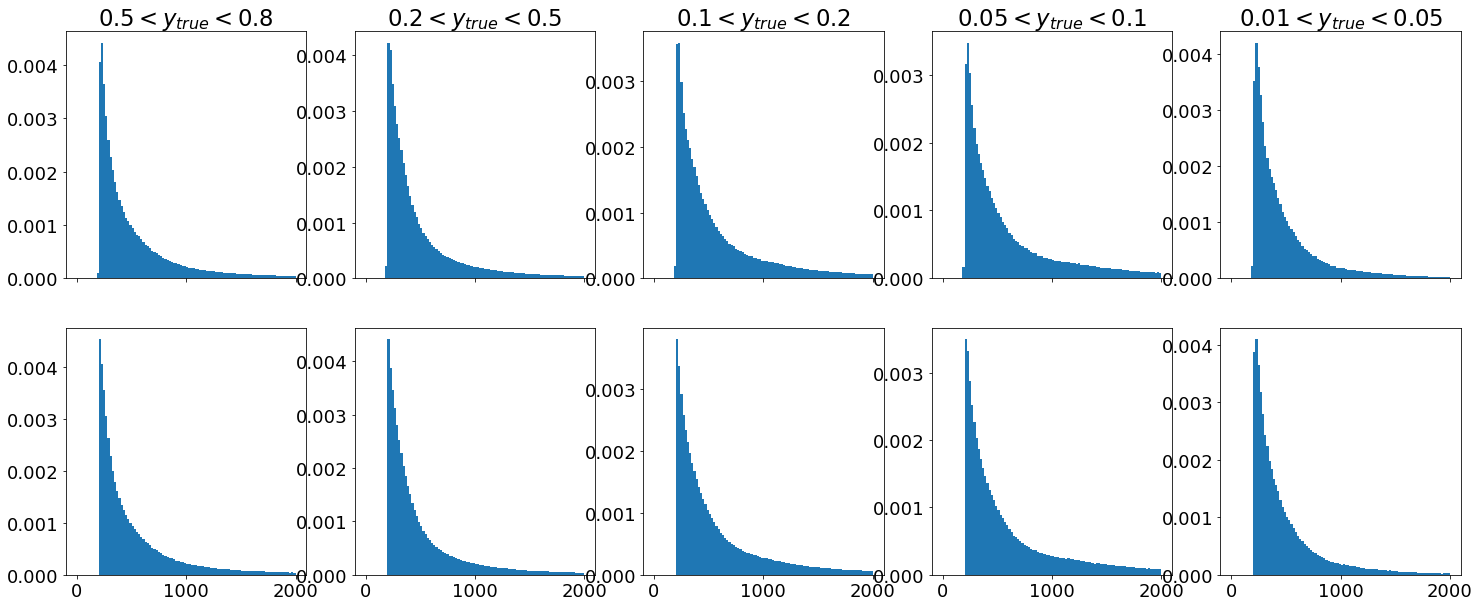

In [41]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 2000

ax[0][0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

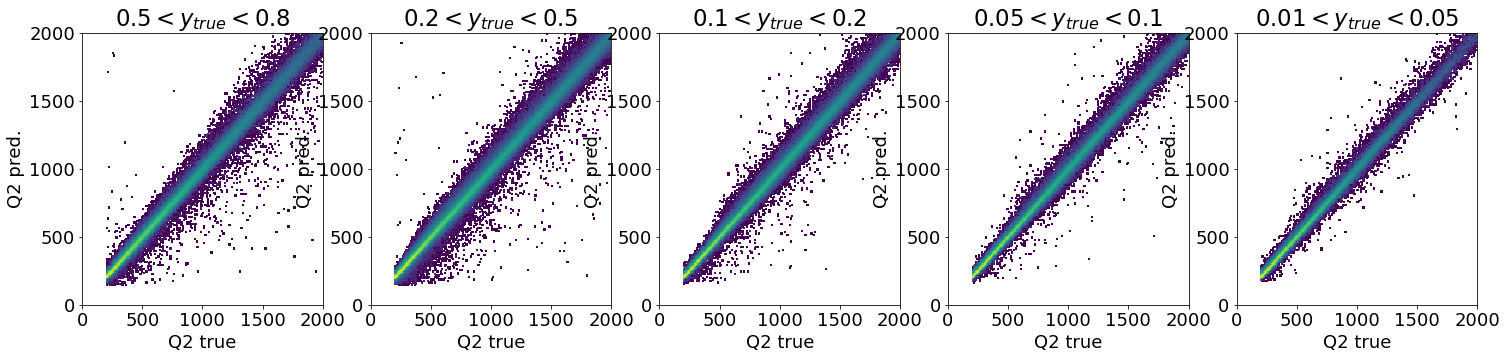

In [42]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 2000

ax[0].hist2d( true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('Q2 pred.')
    ax[i].set_xlabel('Q2 true')


    
plt.show()

## Plots of predicted and true physics variable : y

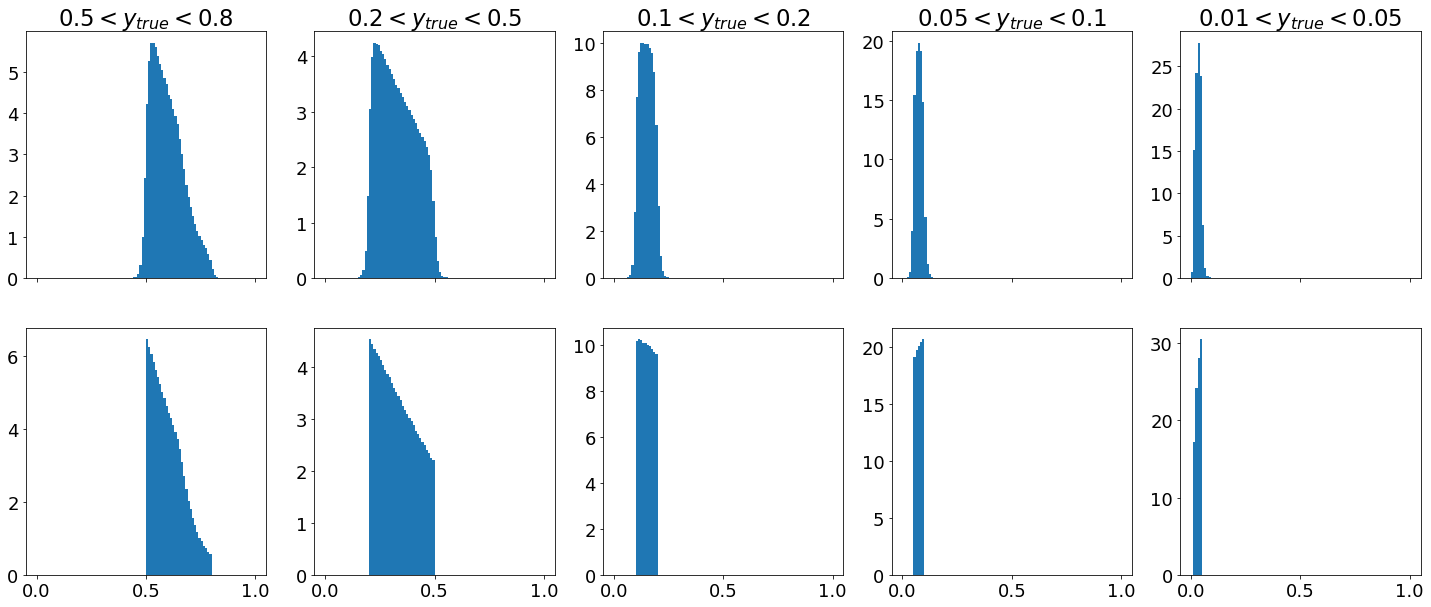

In [43]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

xmax = 1

ax[0][0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[0][1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[0][2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[0][3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[0][4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))

ax[1][0].hist(true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],density=True,bins=100,range=(0,xmax))
ax[1][1].hist(true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],density=True,bins=100,range=(0,xmax))
ax[1][2].hist(true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],density=True,bins=100,range=(0,xmax))
ax[1][3].hist(true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],density=True,bins=100,range=(0,xmax))
ax[1][4].hist(true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],density=True,bins=100,range=(0,xmax))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

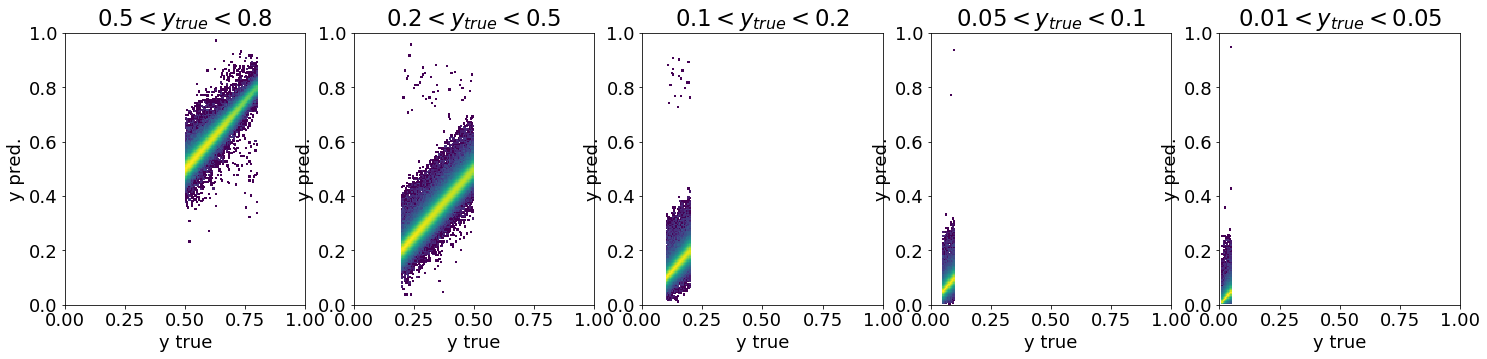

In [44]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

axis_max = 1

ax[0].hist2d( true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],
              pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())

ax[1].hist2d( true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],
              pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[2].hist2d( true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],
              pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[3].hist2d( true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],
              pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())


ax[4].hist2d( true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],
              pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)],                
              density=True,bins=200,range=([0,axis_max],[0,axis_max]), norm=mpl.colors.LogNorm())








ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('y pred.')
    ax[i].set_xlabel('y true')


    
plt.show()

## Plots of pred/true of physics variable x

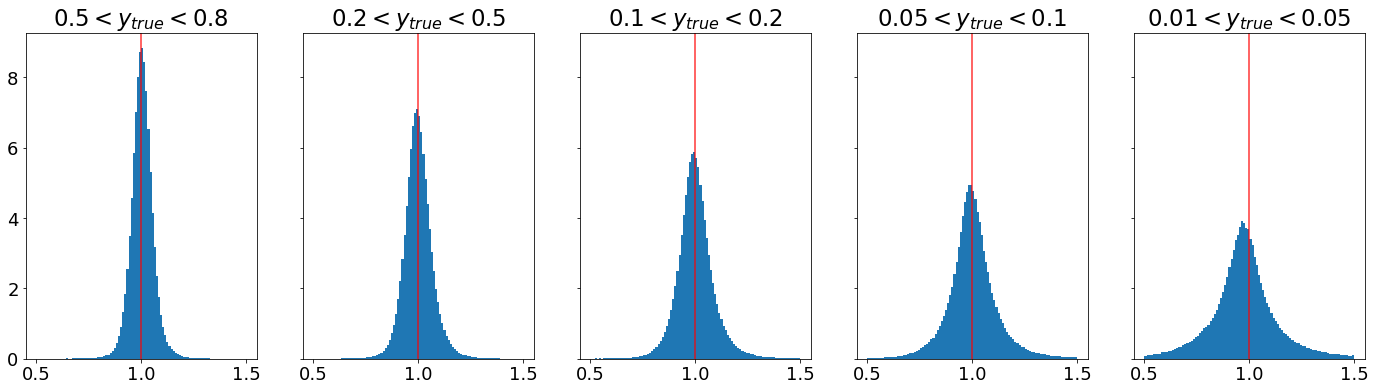

In [45]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable Q2

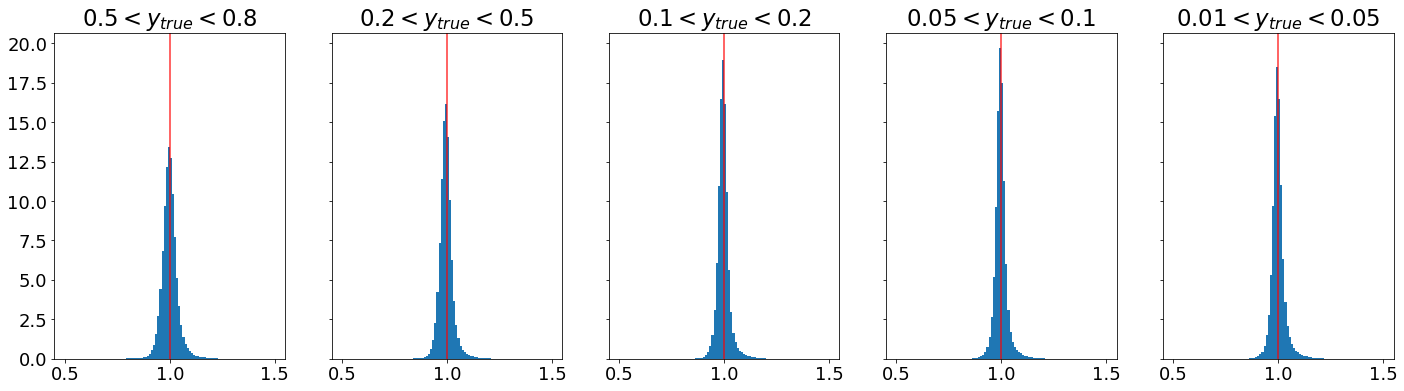

In [46]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Plots of pred/true of physics variable y

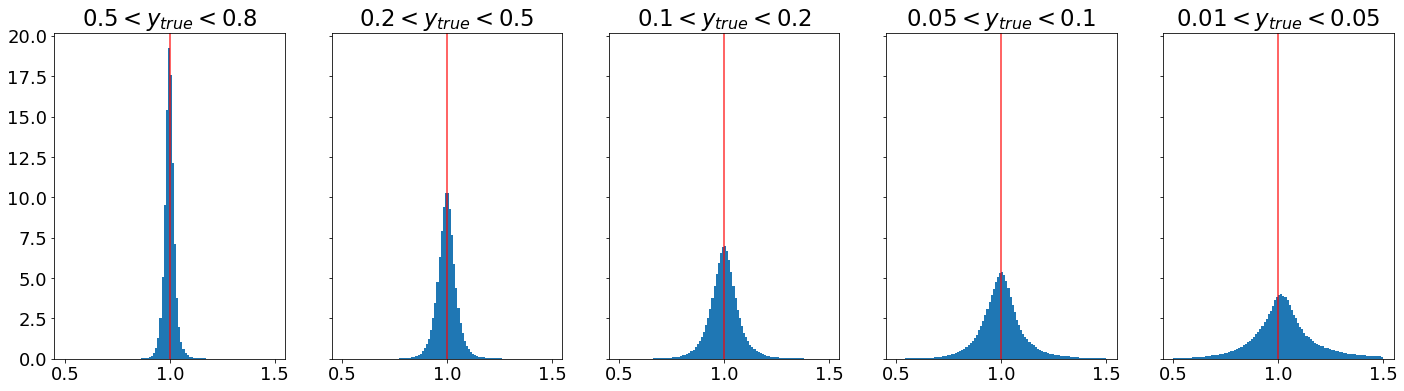

In [47]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

xmin = 0.5
xmax = 1.5

ax[0].hist(pred_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,2][(GY_test > 0.5)*(GY_test < 0.8)], density=True,bins=100,range=(xmin,xmax))
ax[1].hist(pred_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,2][(GY_test > 0.2)*(GY_test < 0.5)], density=True,bins=100,range=(xmin,xmax))
ax[2].hist(pred_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,2][(GY_test > 0.1)*(GY_test < 0.2)], density=True,bins=100,range=(xmin,xmax))
ax[3].hist(pred_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,2][(GY_test > 0.05)*(GY_test < 0.1)], density=True,bins=100,range=(xmin,xmax))
ax[4].hist(pred_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,2][(GY_test > 0.01)*(GY_test < 0.05)], density=True,bins=100,range=(xmin,xmax))






ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Comparison plots of resolution for methods vs DNN


## resolution in x

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

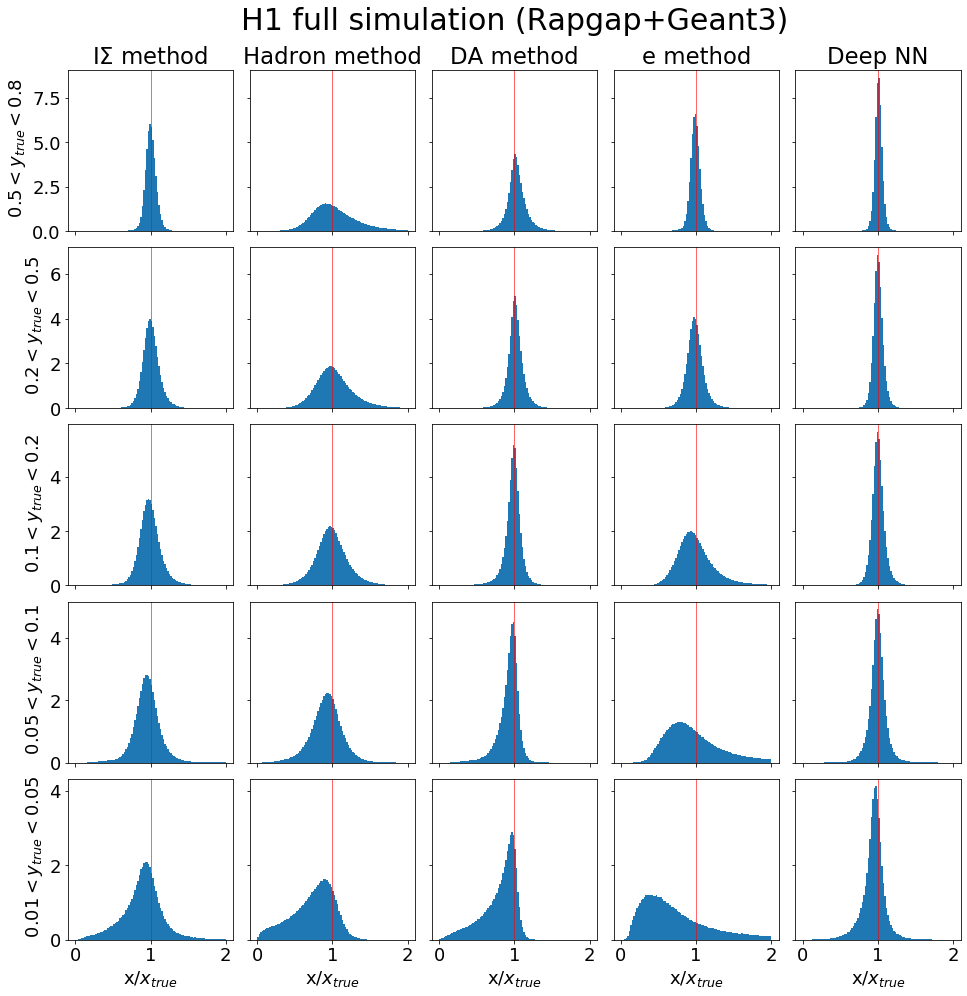

In [48]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

xmin = 0.0
xmax = 2.0

if xaxis_range == 'medium':
    xmin = 0.5
    xmax = 1.5    

if xaxis_range == 'wide':
    xmin = 0.0
    xmax = 2.0       
    
y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_x[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_x'], 
                       density=True, weights=pandas_df.query(y_cut[yi])['wgt'], bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.5)*(GY_test < 0.8)], bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.2)*(GY_test < 0.5)], bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.1)*(GY_test < 0.2)], bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.05)*(GY_test < 0.1)], bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.01)*(GY_test < 0.05)], bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('x/$x_{true}$')
ax[4][1].set_xlabel('x/$x_{true}$')
ax[4][2].set_xlabel('x/$x_{true}$')
ax[4][3].set_xlabel('x/$x_{true}$')
ax[4][4].set_xlabel('x/$x_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ymin,ymax = ax[0][2].get_ylim()
print('y axis range:  %g %g' % (ymin, ymax))
ax[0][2].text( 1., 1.25 * ymax, 'H1 full simulation (Rapgap+Geant3)', horizontalalignment = 'center', fontsize=30)
    
        
        
if save_plots :
    plt.savefig('%s/deepNN-x-resolution-H1-Q2gt200-CthenR-%s.pdf' % (plots_dir, plot_string), bbox_inches='tight' )
    plt.savefig('%s/deepNN-x-resolution-H1-Q2gt200-CthenR-%s.png' % (plots_dir, plot_string), bbox_inches='tight' )
    



## resolution in Q2

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

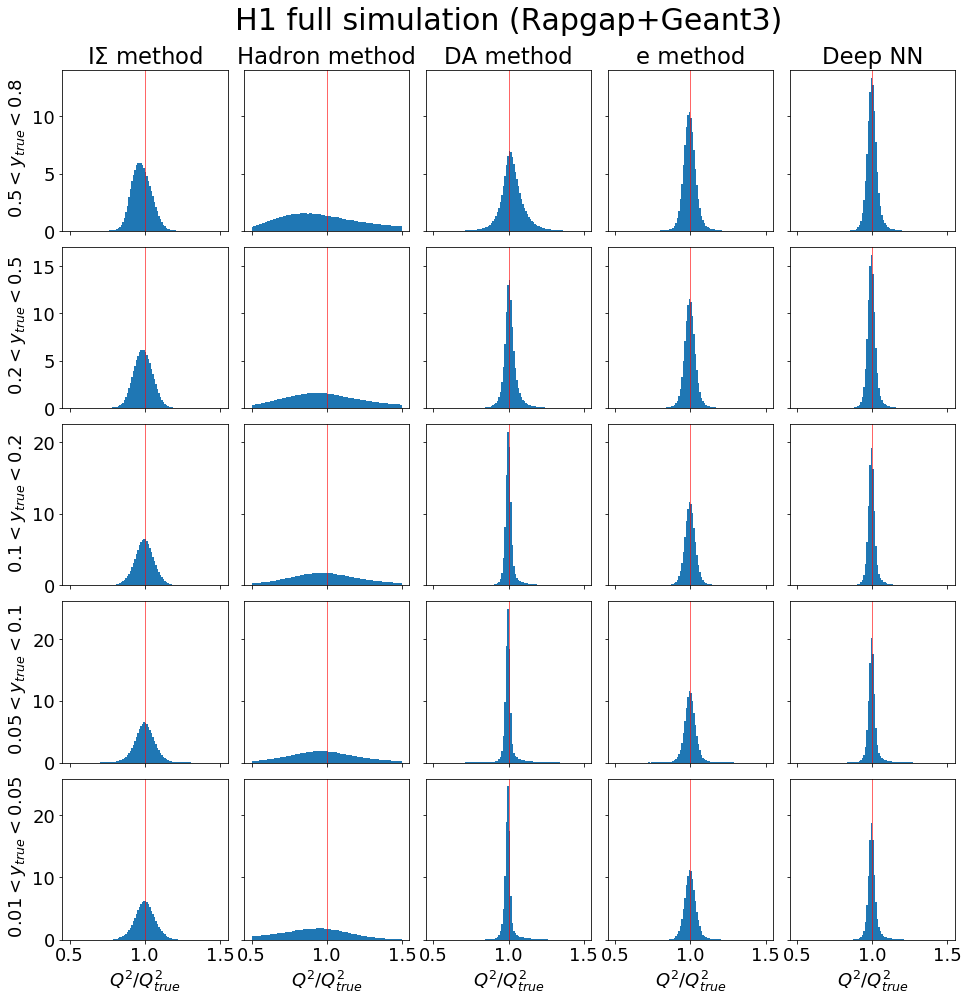

In [49]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 1

xmin = 0.5
xmax = 1.5


if xaxis_range == 'medium':
    xmin = 0.6
    xmax = 1.4    

if xaxis_range == 'wide':
    xmin = 0.0
    xmax = 2.0  
    
y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_Q2[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'], 
                       density=True, weights=pandas_df.query(y_cut[yi])['wgt'], bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.5)*(GY_test < 0.8)], bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.2)*(GY_test < 0.5)], bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.1)*(GY_test < 0.2)], bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.05)*(GY_test < 0.1)], bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.01)*(GY_test < 0.05)], bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][1].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][2].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][3].set_xlabel('$Q^2/Q^2_{true}$')
ax[4][4].set_xlabel('$Q^2/Q^2_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ymin,ymax = ax[0][2].get_ylim()
print('y axis range:  %g %g' % (ymin, ymax))
ax[0][2].text( 1., 1.25 * ymax, 'H1 full simulation (Rapgap+Geant3)', horizontalalignment = 'center', fontsize=30)
   
        
if save_plots :
    plt.savefig('%s/deepNN-Q2-resolution-H1-Q2gt200-CthenR-%s.pdf' % (plots_dir, plot_string), bbox_inches='tight' )
    plt.savefig('%s/deepNN-Q2-resolution-H1-Q2gt200-CthenR-%s.png' % (plots_dir, plot_string), bbox_inches='tight' )
        


## Resolution in y

   0,  0,  5 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0,  5 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0,  5 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0,  5 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0,  5 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1,  4 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1,  4 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1,  4 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1,  4 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1,  4 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2,  3 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2,  3 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2,  3 : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2,  3 : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2,  3 : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  3,  0 : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  3,  0 : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.

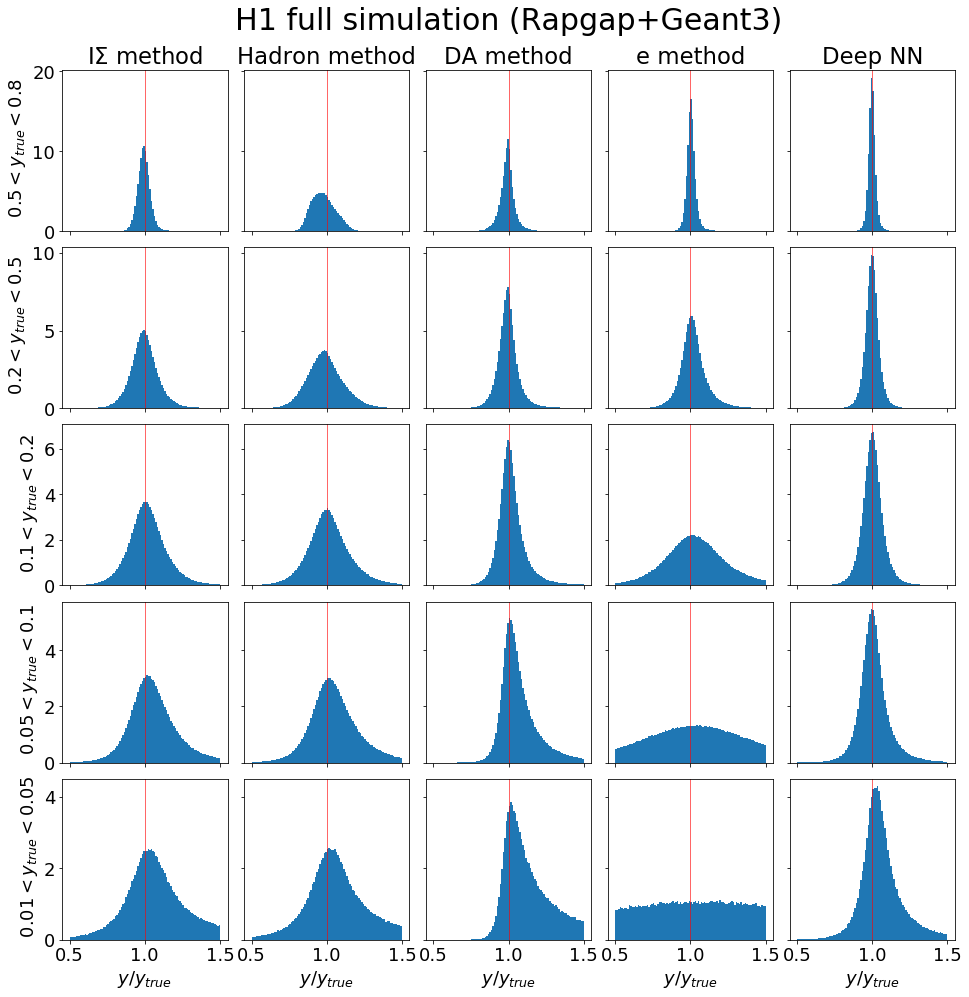

In [50]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

methods_to_use = [5, 4, 3, 0]

nn_output_index = 2

#xmin = 0.90
#xmax = 1.10

xmin = 0.5
xmax = 1.5

if xaxis_range == 'medium':
    xmin = 0.5
    xmax = 1.5
    
if xaxis_range == 'wide':
    xmin = 0.0
    xmax = 2.0  

y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    mi = methods_to_use[i]
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %2d : %s' % (yi, i, mi, y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])['obs_y[%d]' % mi ]/pandas_df.query(y_cut[yi])['from_tlv_gen_y'], 
                       density=True, weights=pandas_df.query(y_cut[yi])['wgt'], bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,nn_output_index][(GY_test > 0.5)*(GY_test < 0.8)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.5)*(GY_test < 0.8)], bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,nn_output_index][(GY_test > 0.2)*(GY_test < 0.5)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.2)*(GY_test < 0.5)], bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,nn_output_index][(GY_test > 0.1)*(GY_test < 0.2)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.1)*(GY_test < 0.2)], bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,nn_output_index][(GY_test > 0.05)*(GY_test < 0.1)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.05)*(GY_test < 0.1)], bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,nn_output_index][(GY_test > 0.01)*(GY_test < 0.05)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.01)*(GY_test < 0.05)], bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('I$\Sigma$ method')
ax[0][1].set_title('Hadron method')
ax[0][2].set_title('DA method')
ax[0][3].set_title('e method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{true}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{true}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{true}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{true}<0.05$')

ax[4][0].set_xlabel('$y/y_{true}$')
ax[4][1].set_xlabel('$y/y_{true}$')
ax[4][2].set_xlabel('$y/y_{true}$')
ax[4][3].set_xlabel('$y/y_{true}$')
ax[4][4].set_xlabel('$y/y_{true}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ymin,ymax = ax[0][2].get_ylim()
print('y axis range:  %g %g' % (ymin, ymax))
ax[0][2].text( 1., 1.25 * ymax, 'H1 full simulation (Rapgap+Geant3)', horizontalalignment = 'center', fontsize=30)

        
        
        
if save_plots :
    plt.savefig('%s/deepNN-y-resolution-H1-Q2gt200-CthenR-%s.pdf' % (plots_dir, plot_string), bbox_inches='tight' )
    plt.savefig('%s/deepNN-y-resolution-H1-Q2gt200-CthenR-%s.png' % (plots_dir, plot_string), bbox_inches='tight' )


        


### New, more compact format

In [51]:
def draw_compact_fig( use_logy=True ):
    
    fig,ax = plt.subplots(2,3,figsize=(20,12),sharex='col',sharey='row')

    methods_to_use = [5, 4, 3, 0]

    nn_output_index = 0

    method_index_1 = 3
    method_label_1 = 'DA'

    method_index_2 = 0
    method_label_2 = 'electron'

    y_division = 0.15

    x_axis_delta_x  = 0.5
    x_axis_delta_y  = 0.5
    x_axis_delta_q2  = 0.2

#    x_axis_delta_x  = 1
#    x_axis_delta_y  = 1
#    x_axis_delta_q2  = 1
    
#    x_axis_delta_x  = 0.8
#    x_axis_delta_y  = 0.8
#    x_axis_delta_q2  = 0.4

    nbins=80


    xmin = 1 - x_axis_delta_x
    xmax = 1 + x_axis_delta_x

    ax[0][2].hist(pred_vals[:,0][(GY_test > y_division)]/true_vals[:,0][(GY_test > y_division)], density=True, bins=nbins, range=(xmin,xmax), label='DNN', alpha=0.7 )

    ax[0][2].hist( pandas_df.query('from_tlv_gen_y>%.2f' % y_division )[ 'obs_x[%d]' % method_index_1 ]/pandas_df.query('from_tlv_gen_y>%.2f' % y_division )['from_tlv_gen_x'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='red', lw=2, label=method_label_1, ls=':'   )    
    ax[0][2].hist( pandas_df.query('from_tlv_gen_y>%.2f' % y_division )[ 'obs_x[%d]' % method_index_2 ]/pandas_df.query('from_tlv_gen_y>%.2f' % y_division )['from_tlv_gen_x'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='black', lw=2, label=method_label_2)   
    ax[0][2].legend(loc='best',fontsize=19)



    xmin = 1 - x_axis_delta_y
    xmax = 1 + x_axis_delta_y

    ax[0][1].hist(pred_vals[:,2][(GY_test > y_division)]/true_vals[:,2][(GY_test > y_division)], density=True,bins=nbins,range=(xmin,xmax), label='DNN', alpha=0.7 )

    ax[0][1].hist( pandas_df.query('from_tlv_gen_y>%.2f' % y_division )[ 'obs_y[%d]' % method_index_1 ]/pandas_df.query('from_tlv_gen_y>%.2f' % y_division )['from_tlv_gen_y'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='red', lw=2, label=method_label_1, ls=':'   )       
    ax[0][1].hist( pandas_df.query('from_tlv_gen_y>%.2f' % y_division )[ 'obs_y[%d]' % method_index_2 ]/pandas_df.query('from_tlv_gen_y>%.2f' % y_division )['from_tlv_gen_y'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='black', lw=2, label=method_label_2 )       
    ax[0][1].legend(loc='best',fontsize=19)




    xmin = 1 - x_axis_delta_q2
    xmax = 1 + x_axis_delta_q2

    ax[0][0].hist(pred_vals[:,1][(GY_test > y_division)]/true_vals[:,1][(GY_test > y_division)], density=True,bins=nbins,range=(xmin,xmax), label='DNN', alpha=0.7 )

    ax[0][0].hist( pandas_df.query('from_tlv_gen_y>%.2f' % y_division )['obs_Q2[%d]' % method_index_1 ]/pandas_df.query('from_tlv_gen_y>%.2f' % y_division )['from_tlv_gen_Q2'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='red', lw=2, label=method_label_1, ls=':'   )       
    ax[0][0].hist( pandas_df.query('from_tlv_gen_y>%.2f' % y_division )['obs_Q2[%d]' % method_index_2 ]/pandas_df.query('from_tlv_gen_y>%.2f' % y_division )['from_tlv_gen_Q2'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='black', lw=2, label=method_label_2 )       
    ax[0][0].legend(loc='best',fontsize=19)






    xmin = 1 - x_axis_delta_x
    xmax = 1 + x_axis_delta_x

    ax[1][2].hist(pred_vals[:,0][(GY_test < y_division)]/true_vals[:,0][(GY_test < y_division)], density=True,bins=nbins,range=(xmin,xmax), label='DNN', alpha=0.7 )

    ax[1][2].hist( pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['obs_x[%d]' % method_index_1 ]/pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['from_tlv_gen_x'],
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='red', lw=2, label=method_label_1, ls=':'   )             
    ax[1][2].hist( pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['obs_x[%d]' % method_index_2 ]/pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['from_tlv_gen_x'],
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='black', lw=2, label=method_label_2 )             
    ax[1][2].legend(loc='best',fontsize=19)


    xmin = 1 - x_axis_delta_y
    xmax = 1 + x_axis_delta_y

    ax[1][1].hist(pred_vals[:,2][(GY_test < 0.2)]/true_vals[:,2][(GY_test < 0.2)], density=True,bins=nbins,range=(xmin,xmax), label='DNN', alpha=0.7 )

    ax[1][1].hist( pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['obs_y[%d]' % method_index_1 ]/pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['from_tlv_gen_y'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='red', lw=2, label=method_label_1, ls=':'   ) 
    ax[1][1].hist( pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['obs_y[%d]' % method_index_2 ]/pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['from_tlv_gen_y'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='black', lw=2, label=method_label_2 ) 
    ax[1][1].legend(loc='best',fontsize=19)


    xmin = 1 - x_axis_delta_q2
    xmax = 1 + x_axis_delta_q2

    ax[1][0].hist(pred_vals[:,1][(GY_test < 0.2)]/true_vals[:,1][(GY_test < 0.2)], density=True,bins=nbins,range=(xmin,xmax), label='DNN', alpha=0.7 )

    ax[1][0].hist( pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['obs_Q2[%d]' % method_index_1 ]/pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['from_tlv_gen_Q2'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='red', lw=2, label=method_label_1, ls=':'   ) 
    ax[1][0].hist( pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['obs_Q2[%d]' % method_index_2 ]/pandas_df.query('from_tlv_gen_y<%.2f' % y_division )['from_tlv_gen_Q2'], 
                  density=True, bins=nbins, range=(xmin, xmax),histtype='step',color='black', lw=2, label=method_label_2 ) 
    ax[1][0].legend(loc='best',fontsize=19)






    #ax[0][0].set_title('I$\Sigma$ method')


    ax[0][0].set_ylabel(' $y_{true}>%.2f$' % y_division )
    ax[1][0].set_ylabel(' $y_{true}<%.2f$' % y_division )

    ax[1][2].set_xlabel('$x/x_{true}$')
    ax[1][1].set_xlabel('$y/y_{true}$')
    ax[1][0].set_xlabel('$Q^2/Q^2_{true}$')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)


    for i in range(2):
        for j in range(3):
            ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
            if use_logy :
                ax[i][j].set_yscale('log')
                ax[i][j].set_ylim(0.05,100)


    ymin,ymax = ax[0][1].get_ylim()
    print('y axis range:  %g %g' % (ymin, ymax))
    ypos = 1.05
    if use_logy: ypos = 1.40
    ax[0][1].text( 1., ypos * ymax, 'H1 full simulation (Rapgap+Geant3)', horizontalalignment = 'center', fontsize=30)



    if save_plots :
        logy_label = ''
        if use_logy:
            logy_label = 'logy-'
        plt.savefig('%s/deepNN-xyQ2-resolution-H1-Q2gt200-%s%s.pdf' % (plots_dir, logy_label, plot_string), bbox_inches='tight' )
        plt.savefig('%s/deepNN-xyQ2-resolution-H1-Q2gt200-%s%s.png' % (plots_dir, logy_label, plot_string), bbox_inches='tight' )


    plt.show()





y axis range:  0.05 100


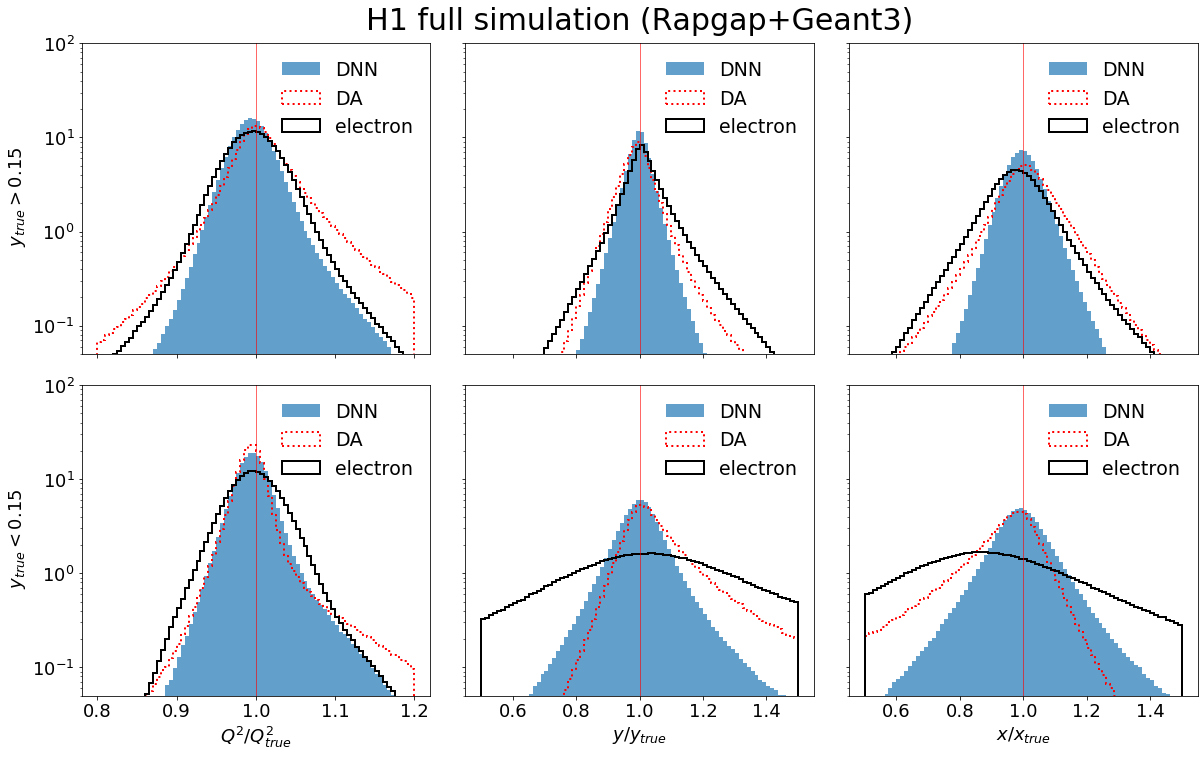

In [52]:
draw_compact_fig(True)

y axis range:  0 16.8265


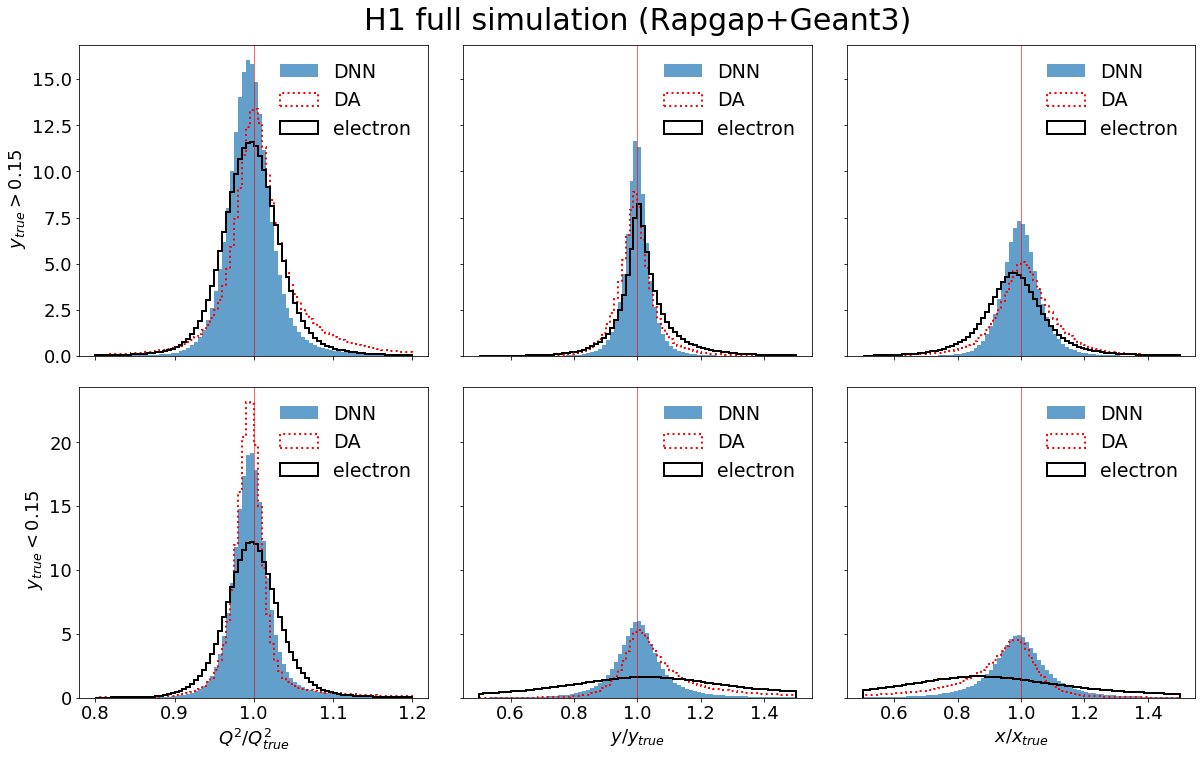

In [53]:
draw_compact_fig(False)

In [54]:

if plot_string == 'allevts':

    root_file = uproot3.recreate('%s/dnn-output-h1.root' % plots_dir )

    root_file['dnnout'] = uproot3.newtree(
        {
            'true_x': np.float32,
            'true_y' : np.float32,
            'true_q2' : np.float32,
            'dnn_x' : np.float32,
            'dnn_y' : np.float32,
            'dnn_q2' : np.float32,
            'has_isr' : bool,
            'has_fsr' : bool,
            'has_norad' : bool,
            'rec_x_e' : np.float32,
            'rec_y_e' : np.float32,
            'rec_q2_e' : np.float32,
            'rec_x_da' : np.float32,
            'rec_y_da' : np.float32,
            'rec_q2_da' : np.float32,
            'rec_x_h' : np.float32,
            'rec_y_h' : np.float32,
            'rec_q2_h' : np.float32,
            'rec_x_is' : np.float32,
            'rec_y_is' : np.float32,
            'rec_q2_is' : np.float32,
            'wgt' :np.float32,
        }
    )

    root_file['dnnout'].extend(
        {
            'true_x'  : true_vals[:,0],
            'true_y'  : true_vals[:,2],
            'true_q2' : true_vals[:,1],
            'dnn_x'  : pred_vals[:,0],
            'dnn_y'  : pred_vals[:,2],
            'dnn_q2' : pred_vals[:,1],
            'has_isr'   : Ex_isrfsr_test[:,0],
            'has_fsr'   : Ex_isrfsr_test[:,1],
            'has_norad'   : Ex_isrfsr_test[:,2],
            'rec_x_e'  : Ex_obs_e_test[:,0],
            'rec_y_e'  : Ex_obs_e_test[:,2],
            'rec_q2_e' : Ex_obs_e_test[:,1],
            'rec_x_da'  : Ex_obs_da_test[:,0],
            'rec_y_da'  : Ex_obs_da_test[:,2],
            'rec_q2_da' : Ex_obs_da_test[:,1],
            'rec_x_h'  : Ex_obs_h_test[:,0],
            'rec_y_h'  : Ex_obs_h_test[:,2],
            'rec_q2_h' : Ex_obs_h_test[:,1],
            'rec_x_is'  : Ex_obs_is_test[:,0],
            'rec_y_is'  : Ex_obs_is_test[:,2],
            'rec_q2_is' : Ex_obs_is_test[:,1],
            'wgt' : Ex_wgt_test[:,0],
        }
    )

    root_file.close()

### Resolution in x, method set 2

   0,  0, obs_x_ida : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0, obs_x_ida : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0, obs_x_ida : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0, obs_x_ida : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0, obs_x_ida : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1, obs_x_sigma : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1, obs_x_sigma : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1, obs_x_sigma : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1, obs_x_sigma : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1, obs_x_sigma : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2, obs_x_esigma : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2, obs_x_esigma : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2, obs_x_esigma : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2, obs_x_esigma : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2, obs_x_esigma : from_tlv_gen_y>0.01 and from_

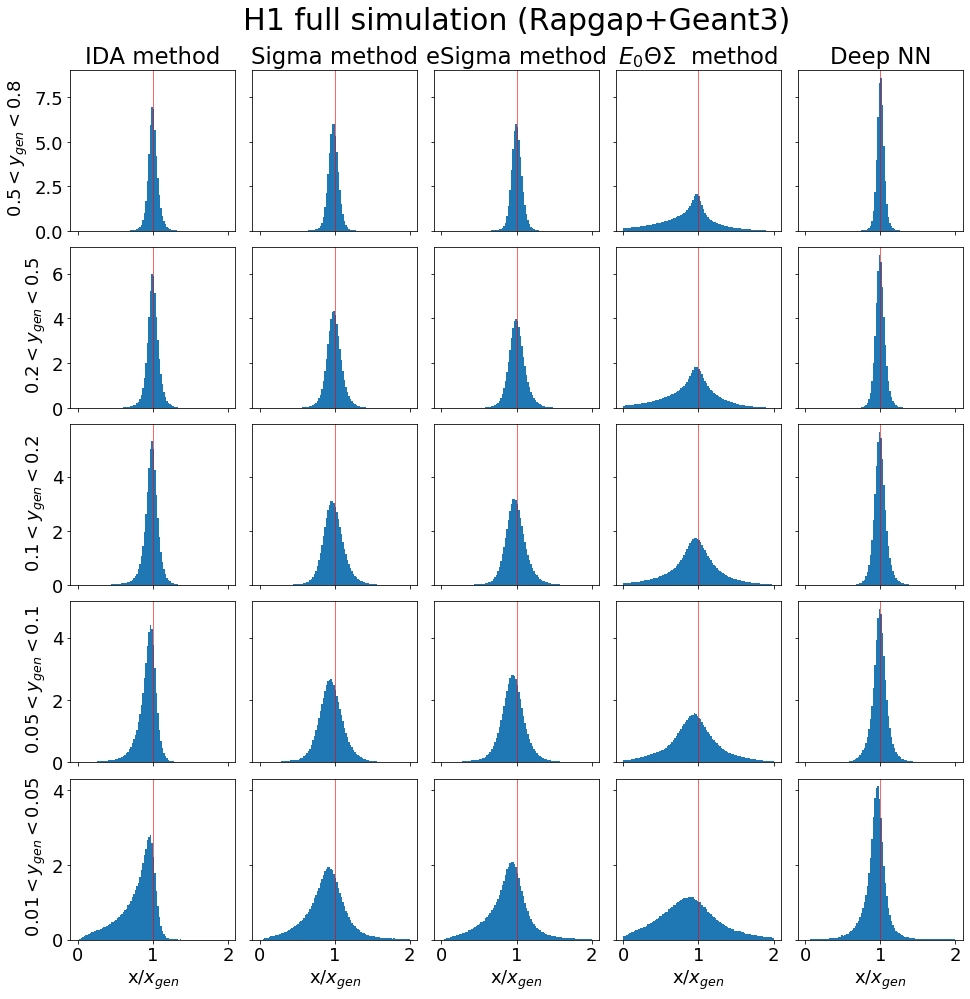

In [61]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

method_keys = ['obs_x_ida','obs_x_sigma','obs_x_esigma','obs_x_e0esigma']

xmin = 0.0
xmax = 2.0

if xaxis_range == 'medium':
    xmin = 0.5
    xmax = 1.5    

if xaxis_range == 'wide':
    xmin = 0.0
    xmax = 2.0       
    
y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %s : %s' % (yi, i, method_keys[i], y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])[method_keys[i]]/pandas_df.query(y_cut[yi])['from_tlv_gen_x'], 
                       density=True, weights=pandas_df.query(y_cut[yi])['wgt'], bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.5)*(GY_test < 0.8)], bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.2)*(GY_test < 0.5)], bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.1)*(GY_test < 0.2)], bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.05)*(GY_test < 0.1)], bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.01)*(GY_test < 0.05)], bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('IDA method')
ax[0][1].set_title('Sigma method')
ax[0][2].set_title('eSigma method')
ax[0][3].set_title('$E_0 \Theta\Sigma$  method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{gen}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{gen}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{gen}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{gen}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{gen}<0.05$')

ax[4][0].set_xlabel('x/$x_{gen}$')
ax[4][1].set_xlabel('x/$x_{gen}$')
ax[4][2].set_xlabel('x/$x_{gen}$')
ax[4][3].set_xlabel('x/$x_{gen}$')
ax[4][4].set_xlabel('x/$x_{gen}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ymin,ymax = ax[0][2].get_ylim()
print('y axis range:  %g %g' % (ymin, ymax))
ax[0][2].text( 1., 1.25 * ymax, 'H1 full simulation (Rapgap+Geant3)', horizontalalignment = 'center', fontsize=30)
    
        
        
if save_plots :
    plt.savefig('%s/deepNN-x-resolution-H1-Q2gt200-set2-%s.pdf' % (plots_dir, plot_string), bbox_inches='tight' )
    plt.savefig('%s/deepNN-x-resolution-H1-Q2gt200-set2-%s.png' % (plots_dir, plot_string), bbox_inches='tight' )
    




### Resolution in x, method set 3

   0,  0, obs_x_e0thetasigma : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0, obs_x_e0thetasigma : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0, obs_x_e0thetasigma : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0, obs_x_e0thetasigma : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0, obs_x_e0thetasigma : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1, obs_x_thetasigmagamma : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1, obs_x_thetasigmagamma : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1, obs_x_thetasigmagamma : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1, obs_x_thetasigmagamma : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1, obs_x_thetasigmagamma : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2, obs_x_esigmat : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2, obs_x_esigmat : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2, obs_x_esigmat : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2, obs_x_esigmat :

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


   1,  3, obs_x_e0et : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  3, obs_x_e0et : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  3, obs_x_e0et : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  3, obs_x_e0et : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
y axis range:  0 9.05287


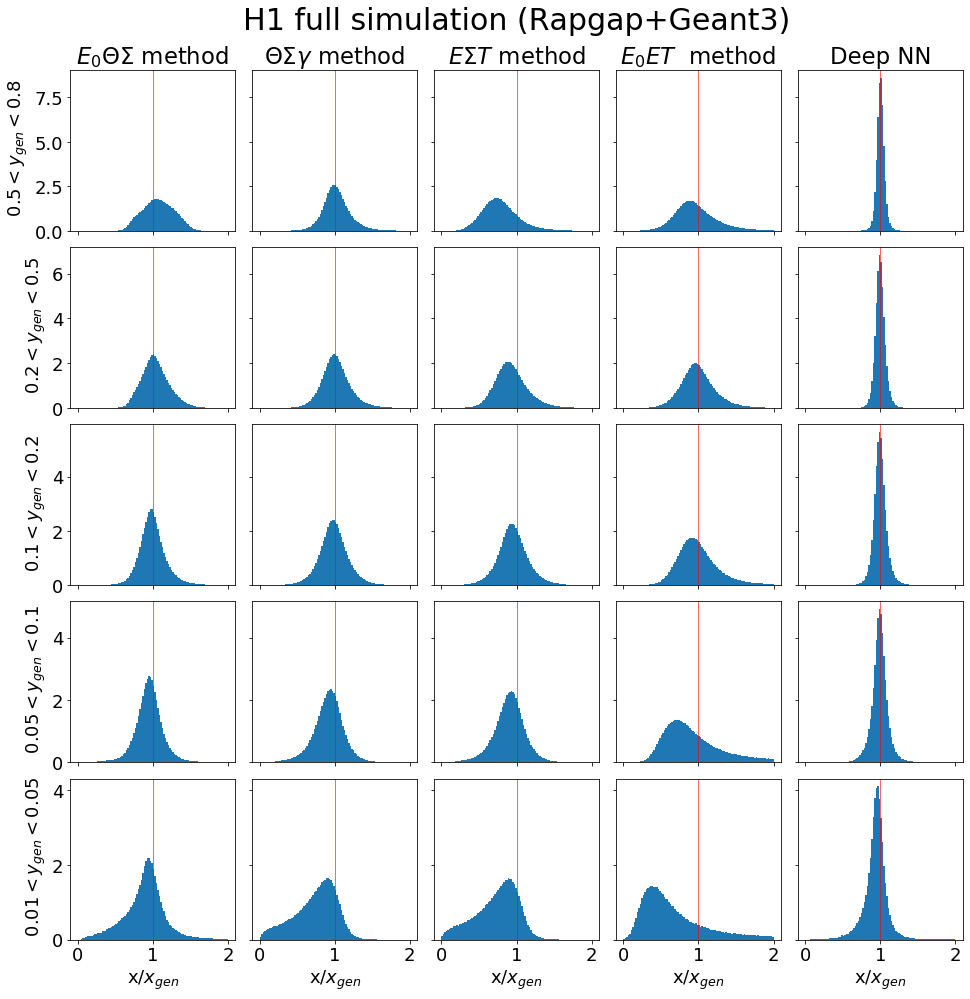

In [62]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

method_keys = ['obs_x_e0thetasigma','obs_x_thetasigmagamma','obs_x_esigmat','obs_x_e0et']

xmin = 0.0
xmax = 2.0

if xaxis_range == 'medium':
    xmin = 0.5
    xmax = 1.5    

if xaxis_range == 'wide':
    xmin = 0.0
    xmax = 2.0       
    
y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %s : %s' % (yi, i, method_keys[i], y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])[method_keys[i]]/pandas_df.query(y_cut[yi])['from_tlv_gen_x'], 
                       density=True, weights=pandas_df.query(y_cut[yi])['wgt'], bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,0][(GY_test > 0.5)*(GY_test < 0.8)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.5)*(GY_test < 0.8)], bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,0][(GY_test > 0.2)*(GY_test < 0.5)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.2)*(GY_test < 0.5)], bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,0][(GY_test > 0.1)*(GY_test < 0.2)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.1)*(GY_test < 0.2)], bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,0][(GY_test > 0.05)*(GY_test < 0.1)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.05)*(GY_test < 0.1)], bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,0][(GY_test > 0.01)*(GY_test < 0.05)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.01)*(GY_test < 0.05)], bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('$E_0 \Theta \Sigma$ method')
ax[0][1].set_title('$\Theta \Sigma \gamma$ method')
ax[0][2].set_title('$E \Sigma T$ method')
ax[0][3].set_title('$E_0 E T$  method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{gen}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{gen}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{gen}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{gen}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{gen}<0.05$')

ax[4][0].set_xlabel('x/$x_{gen}$')
ax[4][1].set_xlabel('x/$x_{gen}$')
ax[4][2].set_xlabel('x/$x_{gen}$')
ax[4][3].set_xlabel('x/$x_{gen}$')
ax[4][4].set_xlabel('x/$x_{gen}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ymin,ymax = ax[0][2].get_ylim()
print('y axis range:  %g %g' % (ymin, ymax))
ax[0][2].text( 1., 1.25 * ymax, 'H1 full simulation (Rapgap+Geant3)', horizontalalignment = 'center', fontsize=30)
    
        
        
if save_plots :
    plt.savefig('%s/deepNN-x-resolution-H1-Q2gt200-set3-%s.pdf' % (plots_dir, plot_string), bbox_inches='tight' )
    plt.savefig('%s/deepNN-x-resolution-H1-Q2gt200-set3-%s.png' % (plots_dir, plot_string), bbox_inches='tight' )
    



### Resolution in Q2, method set 2

   0,  0, obs_q2_ida : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0, obs_q2_ida : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0, obs_q2_ida : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0, obs_q2_ida : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0, obs_q2_ida : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1, obs_q2_sigma : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1, obs_q2_sigma : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1, obs_q2_sigma : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1, obs_q2_sigma : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1, obs_q2_sigma : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2, obs_q2_esigma : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2, obs_q2_esigma : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2, obs_q2_esigma : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2, obs_q2_esigma : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  2, obs_q2_esigma : from_tlv_gen_y

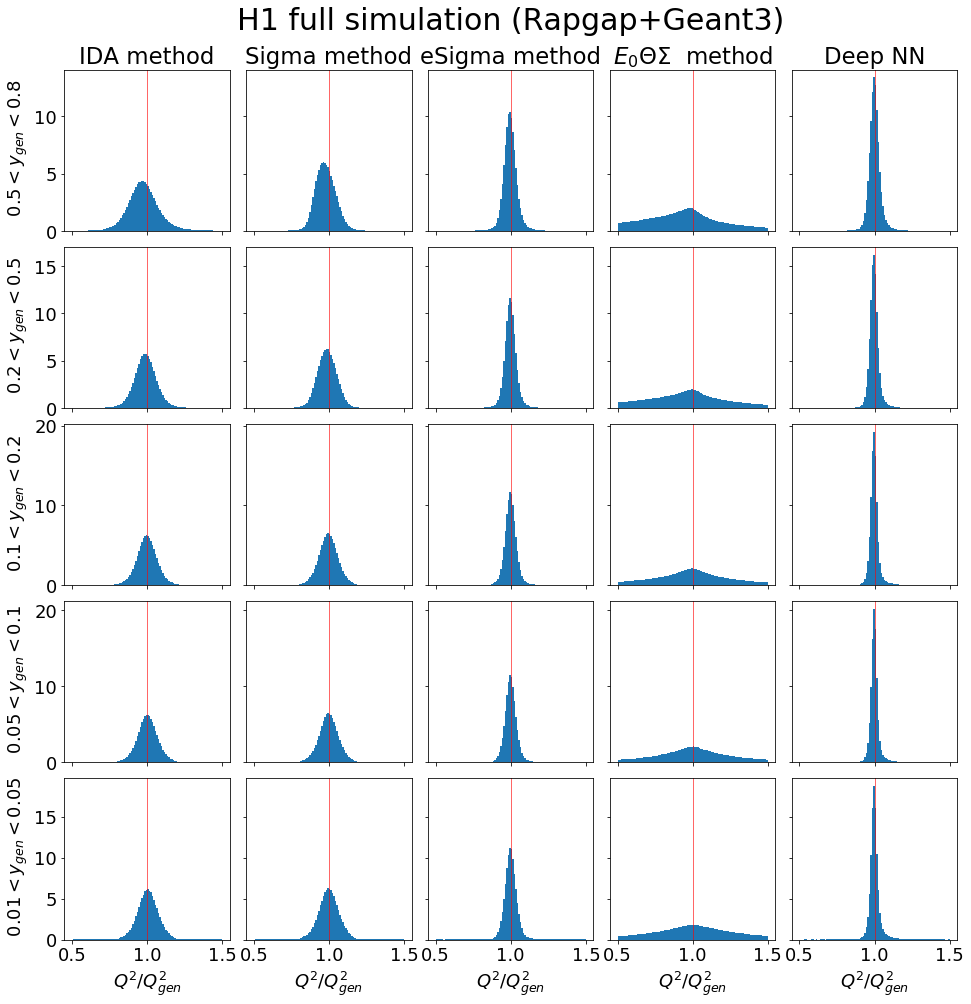

In [59]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

method_keys = ['obs_q2_ida','obs_q2_sigma','obs_q2_esigma','obs_q2_e0esigma']

xmin = 0.5
xmax = 1.5


y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %s : %s' % (yi, i, method_keys[i], y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])[method_keys[i]]/pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'], 
                       density=True, weights=pandas_df.query(y_cut[yi])['wgt'], bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.5)*(GY_test < 0.8)], bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.2)*(GY_test < 0.5)], bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.1)*(GY_test < 0.2)], bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.05)*(GY_test < 0.1)], bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.01)*(GY_test < 0.05)], bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('IDA method')
ax[0][1].set_title('Sigma method')
ax[0][2].set_title('eSigma method')
ax[0][3].set_title('$E_0 \Theta\Sigma$  method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{gen}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{gen}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{gen}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{gen}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{gen}<0.05$')

ax[4][0].set_xlabel('$Q^2/Q^2_{gen}$')
ax[4][1].set_xlabel('$Q^2/Q^2_{gen}$')
ax[4][2].set_xlabel('$Q^2/Q^2_{gen}$')
ax[4][3].set_xlabel('$Q^2/Q^2_{gen}$')
ax[4][4].set_xlabel('$Q^2/Q^2_{gen}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ymin,ymax = ax[0][2].get_ylim()
print('y axis range:  %g %g' % (ymin, ymax))
ax[0][2].text( 1., 1.25 * ymax, 'H1 full simulation (Rapgap+Geant3)', horizontalalignment = 'center', fontsize=30)
    
        
        
if save_plots :
    plt.savefig('%s/deepNN-Q2-resolution-H1-Q2gt200-set2-%s.pdf' % (plots_dir, plot_string), bbox_inches='tight' )
    plt.savefig('%s/deepNN-Q2-resolution-H1-Q2gt200-set2-%s.png' % (plots_dir, plot_string), bbox_inches='tight' )
    





### Resolution in Q2, method set 3

   0,  0, obs_q2_e0thetasigma : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  0, obs_q2_e0thetasigma : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  0, obs_q2_e0thetasigma : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  0, obs_q2_e0thetasigma : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  0, obs_q2_e0thetasigma : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  1, obs_q2_thetasigmagamma : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  1, obs_q2_thetasigmagamma : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  1, obs_q2_thetasigmagamma : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  1, obs_q2_thetasigmagamma : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  1, obs_q2_thetasigmagamma : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
   0,  2, obs_q2_esigmat : from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80
   1,  2, obs_q2_esigmat : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  2, obs_q2_esigmat : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  2, ob

/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


   1,  3, obs_q2_e0et : from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50
   2,  3, obs_q2_e0et : from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20
   3,  3, obs_q2_e0et : from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10
   4,  3, obs_q2_e0et : from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05
y axis range:  0 14.0576


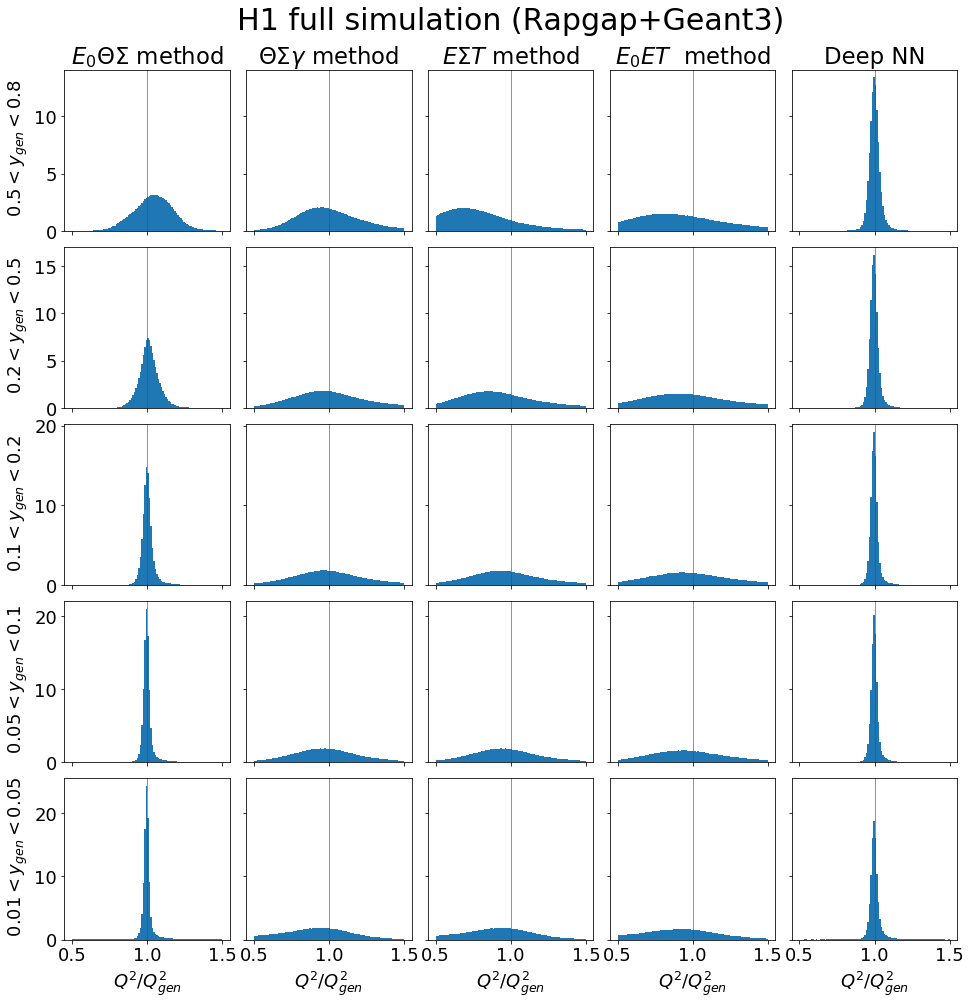

In [60]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)

method_keys = ['obs_q2_e0thetasigma','obs_q2_thetasigmagamma','obs_q2_esigmat','obs_q2_e0et']

xmin = 0.5
xmax = 1.5


y_cut = [
    'from_tlv_gen_y>0.50 and from_tlv_gen_y<0.80',
    'from_tlv_gen_y>0.20 and from_tlv_gen_y<0.50',
    'from_tlv_gen_y>0.10 and from_tlv_gen_y<0.20',
    'from_tlv_gen_y>0.05 and from_tlv_gen_y<0.10',
    'from_tlv_gen_y>0.01 and from_tlv_gen_y<0.05',
]

for i in range(4):
    for yi in range( len(y_cut) ):
        print( '  %2d, %2d, %s : %s' % (yi, i, method_keys[i], y_cut[yi]))
        ax[yi][i].hist( pandas_df.query(y_cut[yi])[method_keys[i]]/pandas_df.query(y_cut[yi])['from_tlv_gen_Q2'], 
                       density=True, weights=pandas_df.query(y_cut[yi])['wgt'], bins=100, range=(xmin, xmax))

ax[0][4].hist(pred_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)]/true_vals[:,1][(GY_test > 0.5)*(GY_test < 0.8)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.5)*(GY_test < 0.8)], bins=100,range=(xmin,xmax))
ax[1][4].hist(pred_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)]/true_vals[:,1][(GY_test > 0.2)*(GY_test < 0.5)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.2)*(GY_test < 0.5)], bins=100,range=(xmin,xmax))
ax[2][4].hist(pred_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)]/true_vals[:,1][(GY_test > 0.1)*(GY_test < 0.2)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.1)*(GY_test < 0.2)], bins=100,range=(xmin,xmax))
ax[3][4].hist(pred_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)]/true_vals[:,1][(GY_test > 0.05)*(GY_test < 0.1)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.05)*(GY_test < 0.1)], bins=100,range=(xmin,xmax))
ax[4][4].hist(pred_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)]/true_vals[:,1][(GY_test > 0.01)*(GY_test < 0.05)], density=True, weights=Ex_wgt_test[:,0][(GY_test > 0.01)*(GY_test < 0.05)], bins=100,range=(xmin,xmax))


        
        
        
ax[0][0].set_title('$E_0 \Theta \Sigma$ method')
ax[0][1].set_title('$\Theta \Sigma \gamma$ method')
ax[0][2].set_title('$E \Sigma T$ method')
ax[0][3].set_title('$E_0 E T$  method')
ax[0][4].set_title('Deep NN')
    
ax[0][0].set_ylabel(' $0.5<y_{gen}<0.8$')
ax[1][0].set_ylabel(' $0.2<y_{gen}<0.5$')
ax[2][0].set_ylabel(' $0.1<y_{gen}<0.2$')
ax[3][0].set_ylabel(' $0.05<y_{gen}<0.1$')
ax[4][0].set_ylabel(' $0.01<y_{gen}<0.05$')

ax[4][0].set_xlabel('$Q^2/Q^2_{gen}$')
ax[4][1].set_xlabel('$Q^2/Q^2_{gen}$')
ax[4][2].set_xlabel('$Q^2/Q^2_{gen}$')
ax[4][3].set_xlabel('$Q^2/Q^2_{gen}$')
ax[4][4].set_xlabel('$Q^2/Q^2_{gen}$')

for i in range(5):
    for j in range(5):
        ax[i][j].axvline(1.0,color='red',lw=1,alpha=0.6)
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ymin,ymax = ax[0][2].get_ylim()
print('y axis range:  %g %g' % (ymin, ymax))
ax[0][2].text( 1., 1.25 * ymax, 'H1 full simulation (Rapgap+Geant3)', horizontalalignment = 'center', fontsize=30)
    
        
        
if save_plots :
    plt.savefig('%s/deepNN-Q2-resolution-H1-Q2gt200-set3-%s.pdf' % (plots_dir, plot_string), bbox_inches='tight' )
    plt.savefig('%s/deepNN-Q2-resolution-H1-Q2gt200-set3-%s.png' % (plots_dir, plot_string), bbox_inches='tight' )
    




